<a href="https://colab.research.google.com/github/sravanikuncham466/DSBA_6165_Forest_Fire_and_Smoke_Detection/blob/main/forest_fire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import tensorflow as tf

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
from tensorflow.keras.applications import vgg16,resnet, MobileNet
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions
from tensorflow.keras.applications.mobilenet import preprocess_input, decode_predictions
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import os
import cv2
import seaborn as sns
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split



In [30]:

#print tensorflow version
print(tf.__version__)

2.18.0


In [31]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [32]:
## set train, validation, and test paths
train_path = '/content/gdrive/MyDrive/project data set/project/data set/dataset main/data 3/Forect Fire/Forest Fire_Dataset/train'
validation_path = '/content/gdrive/MyDrive/project data set/project/data set/dataset main/data 3/Forect Fire/Forest Fire_Dataset/val'
test_path = '/content/gdrive/MyDrive/project data set/project/data set/dataset main/data 3/Forect Fire/Forest Fire_Dataset/test'

The data is structured into three subsets : train, validation and test sets and each containing images categorized into four classes:

* fire
* nofire
* smoke
* smokefire


**Count Images in Each Folder**

In [33]:
import os

def count_images(directory):
    class_counts = {}
    total_images = 0
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            count = len(os.listdir(category_path))
            class_counts[category] = count
            total_images += count
    return class_counts, total_images

# Get counts for train, validation, and test sets
train_counts, train_total = count_images(train_path)
val_counts, val_total = count_images(validation_path)
test_counts, test_total = count_images(test_path)

# Print summary
print("Train Data:", train_counts, "Total:", train_total)
print("Validation Data:", val_counts, "Total:", val_total)
print("Test Data:", test_counts, "Total:", test_total)


Train Data: {'fire': 800, 'nofire': 800, 'smoke': 820, 'smokefire': 800} Total: 3220
Validation Data: {'nofire': 200, 'smokefire': 200, 'fire': 200, 'smoke': 200} Total: 800
Test Data: {'fire': 200, 'nofire': 200, 'smoke': 200, 'smokefire': 200} Total: 800


**Training Data**

Distribution:
* fire : 800 images
* nofire : 800 images
* smoke : 820 images
* smokefire: 800 images

Total images : 3220

* The dataset is balanced, with all the clsses having around 800 images each.
* The training dataset is the largest, ensuring that the model has enough data to learn patterns.

**Validation Data**

Distribution:
* fire : 200 images
* nofire : 200 images
* smoke : 200 images
* smokefire : 200 images

Total Images : 800

* Validation set is balanced across all four classes ( 200 images each ).

* This ensures that the model performance evaluation is unbiased during training.

* The number of images is much smaller comapred to the training set, as validation is mainly used for tuning hyperparameters and preventing overfitting.

**Test Data**

Distribution:
* fire : 200 images
* nofire : 200 images
* smoke : 200 images
* smokefire : 200 images

Total Images : 800

* The test set is balanced across all four classes.
* This ensures the final model is unbiased.
* The test set kept untouched during training to provide realistic estimate of model performance.

 **Check for Corrupt Images**


In [34]:
import cv2

def check_corrupt_images(directory):
    corrupt_images = []
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                try:
                    img = cv2.imread(img_path)
                    if img is None:
                        corrupt_images.append(img_path)
                except:
                    corrupt_images.append(img_path)
    return corrupt_images

# Identify corrupt images
corrupt_train = check_corrupt_images(train_path)
corrupt_val = check_corrupt_images(validation_path)
corrupt_test = check_corrupt_images(test_path)

print(f"Corrupt Train Images: {len(corrupt_train)}")
print(f"Corrupt Validation Images: {len(corrupt_val)}")
print(f"Corrupt Test Images: {len(corrupt_test)}")

# If needed, delete corrupt images
for img in corrupt_train + corrupt_val + corrupt_test:
    os.remove(img)


Corrupt Train Images: 0
Corrupt Validation Images: 0
Corrupt Test Images: 0


* To ensure that only valid images are used , preventing errors during model training we did this step. The goal of this step is to assess the quality of the dataset by identifying and removing corrupt images before training a machine learning model.

* In this step we iterates through all image files in each class.
* Attempts to read each image using cv2.imread(img_path).
* If the image cannot be loaded ( img is none) it is marked as corrupt.
* If any error occurs while reading, the image is added to the corrupt list.

From the output , it is clear that there is no corrupt images were detected across all three subsets.

This means that the dataset is well maintained and free from missing or unreadable image files.

As there is no corrupt images were found, no deletions are required.


**Visualizing**

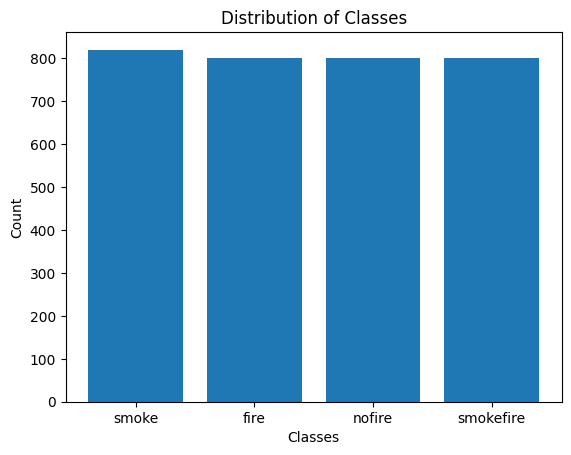

In [35]:
def create_dataframe(directory):
    image_paths = []
    labels = []
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                image_paths.append(image_path)
                labels.append(class_folder)  # Use the folder name as the label
    return pd.DataFrame({'image': image_paths, 'label': labels})

# Create the 'train' DataFrame
train = create_dataframe(train_path)

# Now you can use 'train' in your code:
class_counts = train['label'].value_counts()
plt.bar(class_counts.index, class_counts)
plt.title('Distribution of Classes')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()



The goal of this is to analyze the distribution of different classes in the training dataset by counting the number od images per class and visualizing the distribution using a bar chart.

value_counts() is used to count the number of images per class.

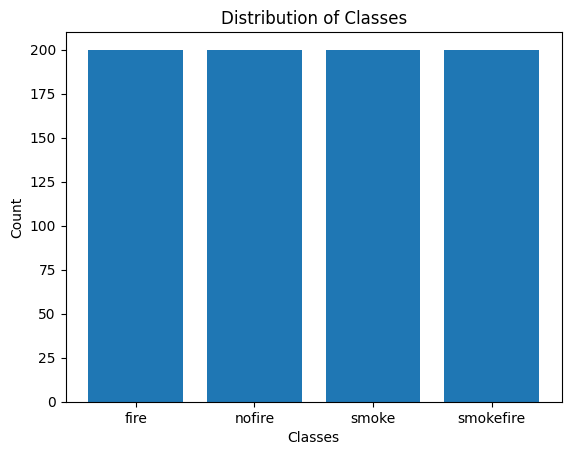

In [36]:
def create_dataframe(directory):
    image_paths = []
    labels = []
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                image_paths.append(image_path)
                labels.append(class_folder)  # Use the folder name as the label
    return pd.DataFrame({'image': image_paths, 'label': labels})

# Create the 'test' DataFrame
test = create_dataframe(test_path)

# Now you can use 'test' in your code:
class_counts = test['label'].value_counts()
plt.bar(class_counts.index, class_counts)
plt.title('Distribution of Classes')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()




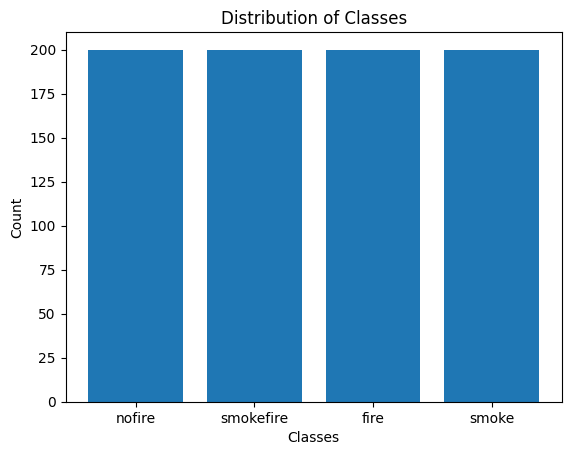

In [37]:
def create_dataframe(directory):
    image_paths = []
    labels = []
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                image_paths.append(image_path)
                labels.append(class_folder)  # Use the folder name as the label
    return pd.DataFrame({'image': image_paths, 'label': labels})

# Create the 'test' DataFrame
val = create_dataframe(validation_path )

# Now you can use 'test' in your code:
class_counts = val['label'].value_counts()
plt.bar(class_counts.index, class_counts)
plt.title('Distribution of Classes')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

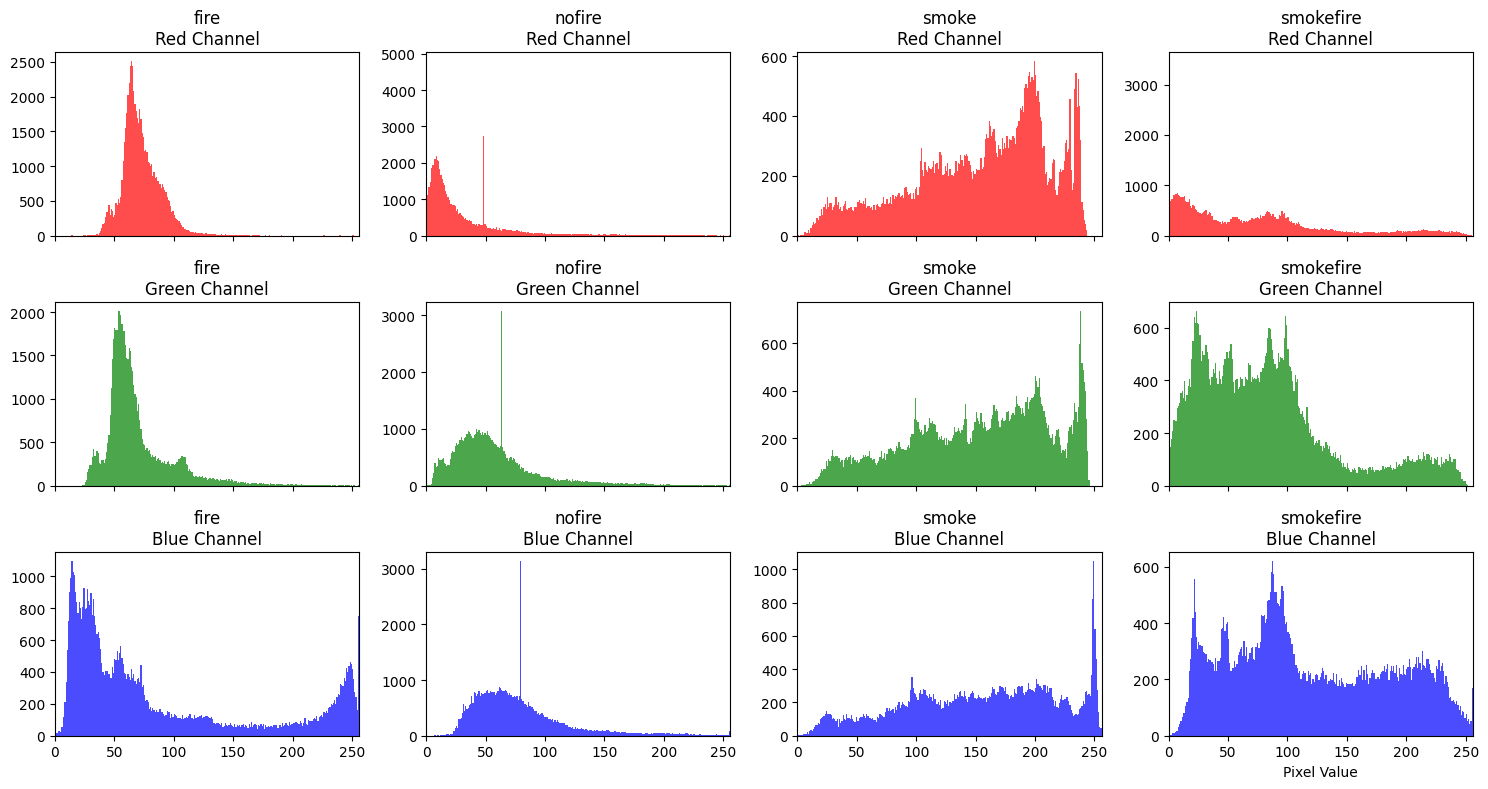

In [38]:
import cv2

# Function to display histograms of the color channels for one image per class
def display_channel_histograms_per_class(data):
    # Create subplots for each color channel
    fig, axes = plt.subplots(3, len(data['label'].unique()), figsize=(15, 8), sharex=True)

    # Loop through unique classes
    for i, class_label in enumerate(data['label'].unique()):
        # Select one image from the current class
        image_path = data[data['label'] == class_label]['image'].iloc[0]
        img = cv2.imread(image_path)

        # Loop through color channels (assuming RGB images)
        for j, color_channel in enumerate(['Red', 'Green', 'Blue']):
            # Plot histogram for the current channel
            axes[j, i].hist(img[:, :, j].ravel(), bins=256, range=(0, 256), color=color_channel.lower(), alpha=0.7)
            axes[j, i].set_title(f'{class_label}\n{color_channel} Channel')
            axes[j, i].set_xlim([0, 256])

    plt.xlabel('Pixel Value')
    plt.tight_layout()
    plt.show()

# Display histograms of the color channels for one image per class in the training data
display_channel_histograms_per_class(train)


In this we are generating histograms for the Red, Green and Blue color channels for one sample image from each class in the dataset.

* fire images have high red intensity - Red channel can be used to detect fire.
* Smoke images have higher blue and green values - these can help separate smoke from fire.
* No fire images have balanced color distributions.
* Smokefire images mix red and blue/ green could help in detecting both elements together.

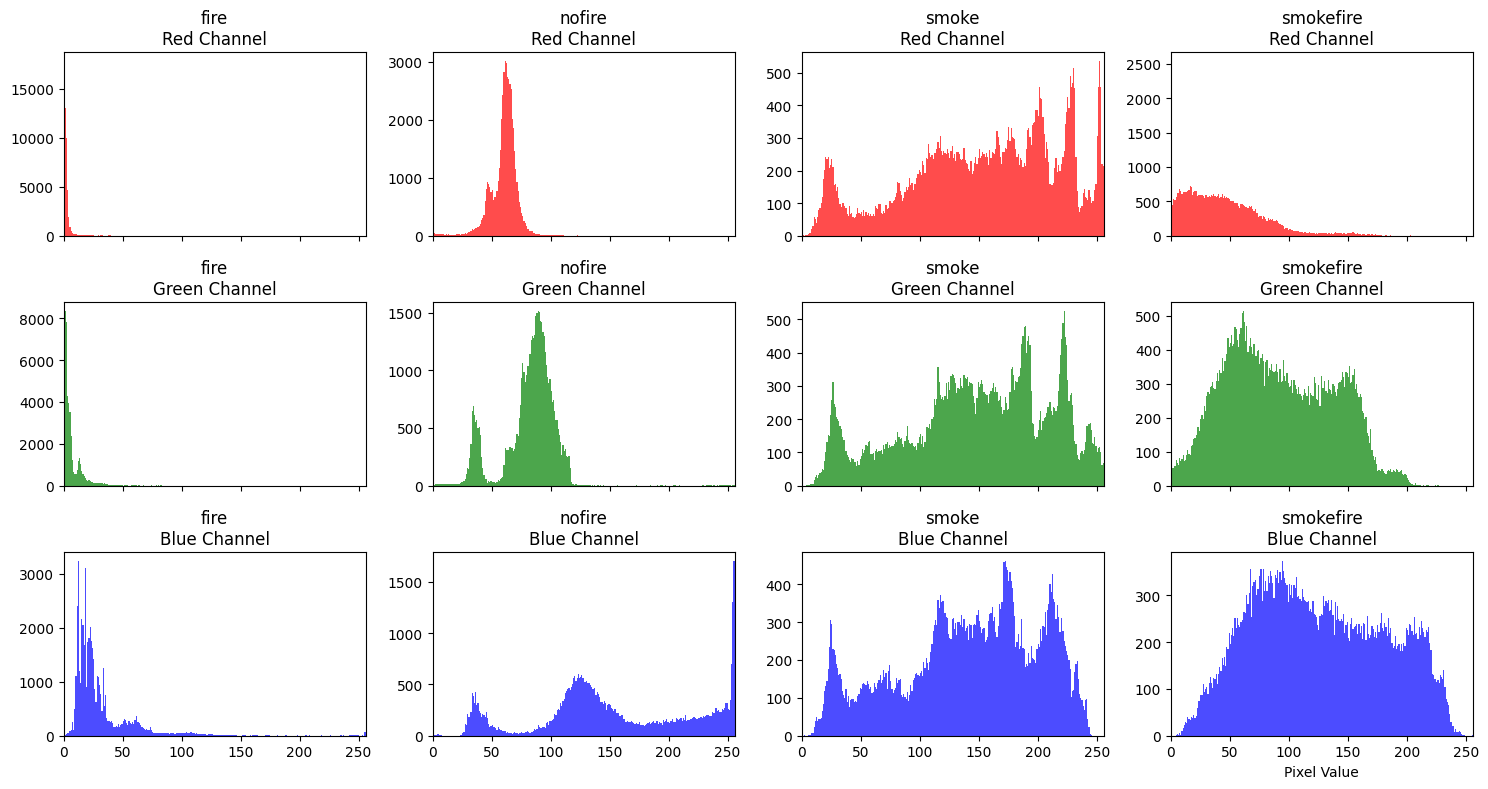

In [39]:
# Function to display histograms of the color channels for one image per class
def display_channel_histograms_per_class(data):
    # Create subplots for each color channel
    fig, axes = plt.subplots(3, len(data['label'].unique()), figsize=(15, 8), sharex=True)

    # Loop through unique classes
    for i, class_label in enumerate(data['label'].unique()):
        # Select one image from the current class
        image_path = data[data['label'] == class_label]['image'].iloc[0]
        img = cv2.imread(image_path)

        # Loop through color channels (assuming RGB images)
        for j, color_channel in enumerate(['Red', 'Green', 'Blue']):
            # Plot histogram for the current channel
            axes[j, i].hist(img[:, :, j].ravel(), bins=256, range=(0, 256), color=color_channel.lower(), alpha=0.7)
            axes[j, i].set_title(f'{class_label}\n{color_channel} Channel')
            axes[j, i].set_xlim([0, 256])

    plt.xlabel('Pixel Value')
    plt.tight_layout()
    plt.show()

# Display histograms of the color channels for one image per class in the training data
display_channel_histograms_per_class(test)


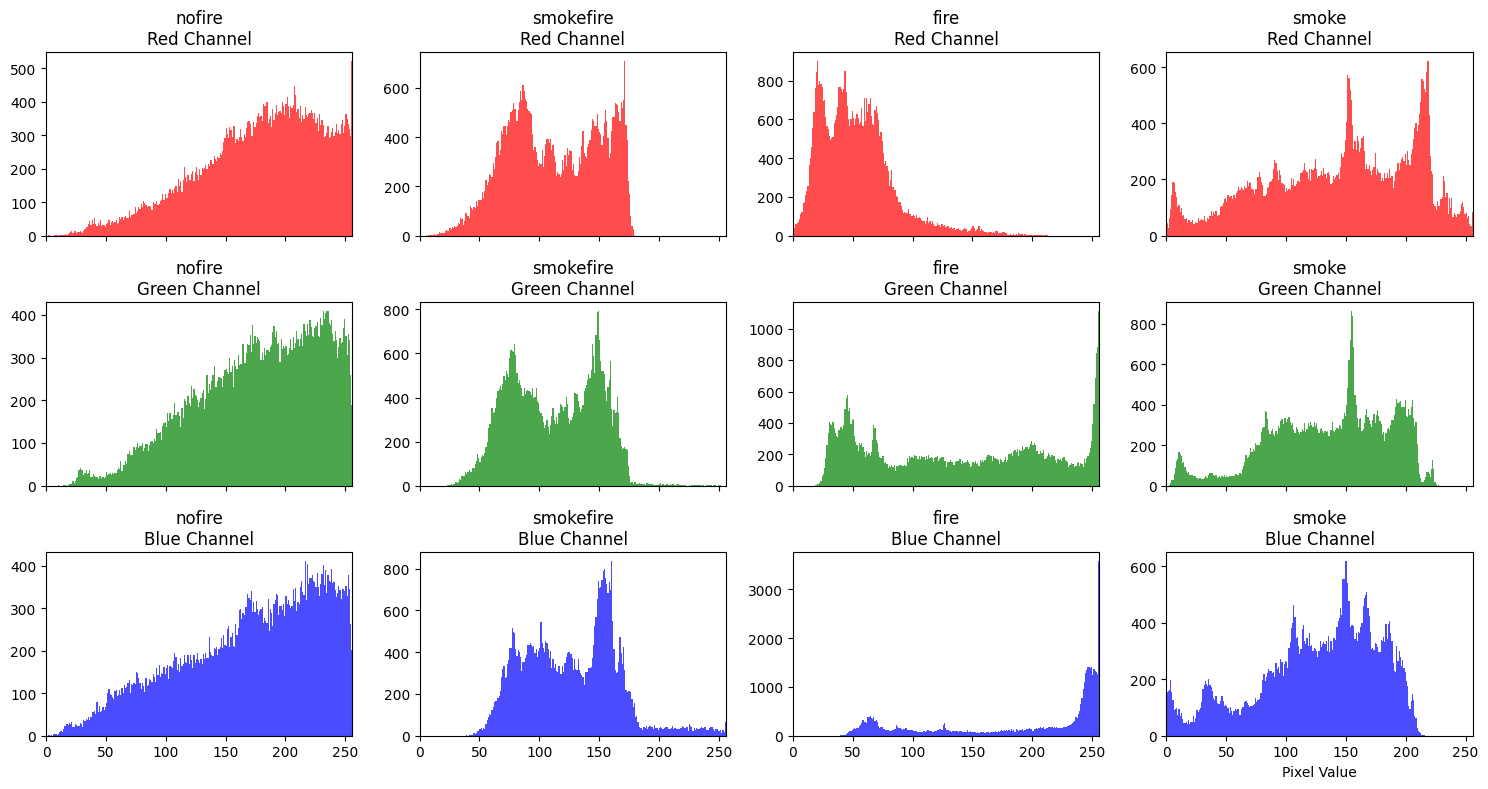

In [40]:
# Function to display histograms of the color channels for one image per class
def display_channel_histograms_per_class(data):
    # Create subplots for each color channel
    fig, axes = plt.subplots(3, len(data['label'].unique()), figsize=(15, 8), sharex=True)

    # Loop through unique classes
    for i, class_label in enumerate(data['label'].unique()):
        # Select one image from the current class
        image_path = data[data['label'] == class_label]['image'].iloc[0]
        img = cv2.imread(image_path)

        # Loop through color channels (assuming RGB images)
        for j, color_channel in enumerate(['Red', 'Green', 'Blue']):
            # Plot histogram for the current channel
            axes[j, i].hist(img[:, :, j].ravel(), bins=256, range=(0, 256), color=color_channel.lower(), alpha=0.7)
            axes[j, i].set_title(f'{class_label}\n{color_channel} Channel')
            axes[j, i].set_xlim([0, 256])

    plt.xlabel('Pixel Value')
    plt.tight_layout()
    plt.show()

# Display histograms of the color channels for one image per class in the training data
display_channel_histograms_per_class(val)


Step 4: Display Sample Images


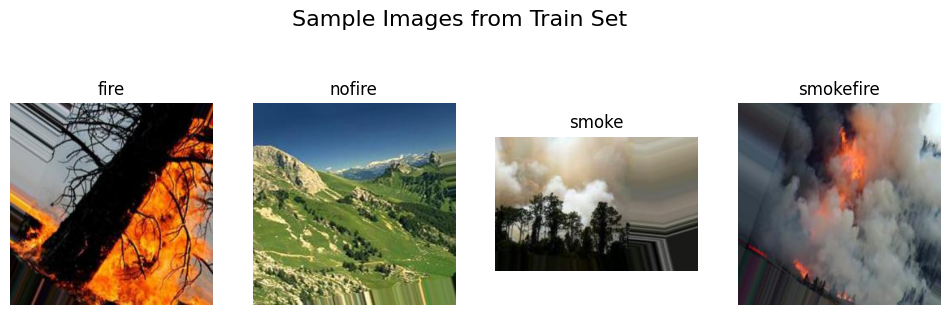

In [41]:
import matplotlib.pyplot as plt
import cv2
import random
import os

def display_images(dataset_path, title, num_cols=4):
    categories = os.listdir(dataset_path)
    categories = [c for c in categories if os.path.isdir(os.path.join(dataset_path, c))]  # Ensure only directories
    num_categories = len(categories)
    num_rows = (num_categories + num_cols - 1) // num_cols  # Calculate required rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))
    fig.suptitle(title, fontsize=16)


    if num_rows == 1 or num_cols == 1:
        axes = axes.flatten() if isinstance(axes, np.ndarray) else axes  # Flatten only if it's a NumPy array
    else:
        axes = axes.flatten()

    for i, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        img_name = random.choice(os.listdir(category_path))  # Pick a random image
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[i].imshow(img)
        axes[i].set_title(category)
        axes[i].axis("off")

    # Hide any unused subplot spaces
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])  # Remove unused axes

    plt.show()

# Display images from the training set
display_images(train_path, "Sample Images from Train Set")

This is used to randomly display sample images from different categories in the dataset.

**Label Encoding**

In [42]:
# Create a label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels in the training data
train['label_code'] = label_encoder.fit_transform(train['label'])

# Display the mapping between labels and their encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:")
print(label_mapping)

Label Mapping:
{'fire': np.int64(0), 'nofire': np.int64(1), 'smoke': np.int64(2), 'smokefire': np.int64(3)}


In this code encodes categorical labels into numberical values using label encoding.

In [43]:
# Create a label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels in the training data
test['label_code'] = label_encoder.fit_transform(test['label'])

# Display the mapping between labels and their encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:")
print(label_mapping)

Label Mapping:
{'fire': np.int64(0), 'nofire': np.int64(1), 'smoke': np.int64(2), 'smokefire': np.int64(3)}


In [44]:
# Create a label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels in the training data
val['label_code'] = label_encoder.fit_transform(val['label'])

# Display the mapping between labels and their encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:")
print(label_mapping)


Label Mapping:
{'fire': np.int64(0), 'nofire': np.int64(1), 'smoke': np.int64(2), 'smokefire': np.int64(3)}


**Data Augmentation**


In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#  Data augmentation only for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

#  No augmentation for validation and test sets (Only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

#  Load training images with augmentation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Load validation images (no augmentation)
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

#  Load test images (no augmentation, no shuffling for evaluation)
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 3220 validated image filenames belonging to 4 classes.
Found 800 validated image filenames belonging to 4 classes.
Found 800 validated image filenames belonging to 4 classes.


In this train_datagen object is used to apply data agumentation to the training dataset.

* rescale=1./255 - It rescales pixel values to be between 0 and 1 by dividing each pixel value by 255. This helps normalize the image data.
* rotation_range=20 - It randomly rotates the image by up to 20 degrees.
* width_shift_range=0.2 - It randomly shifts the image horizontally by up to 20% of the total width.
* height_shift_range=0.2 - Randomly shifts the image vertically by up to 20% of the total height.
* shear_range =0.2 - It distorts by shifting the part of the image.
* zoom_range=0.2 - It zooms in randomly between 80% and 120% of the original image.
* horizontal_flip=True - Flips the image horizontally with a 50% chance.
* fill_mode = 'nearest' - using the nearest pixel value it determines how to fill in pixels taht are shifted outside of the image borders.

* val_test_datagen is used for the validation and test data. Unlike the training data no agumentation is applied here. the only transformation performed is rescaling to normalize the pixel values between 0 and 1.

* resized all images to 224x224 pixels as this is the standard size for CNNs and VGG16 and ResNet.

* as it is a multi classification problem the class mode is set as categorical, the labels will be one hot encoded.

Displaying images after augmentation and resizing


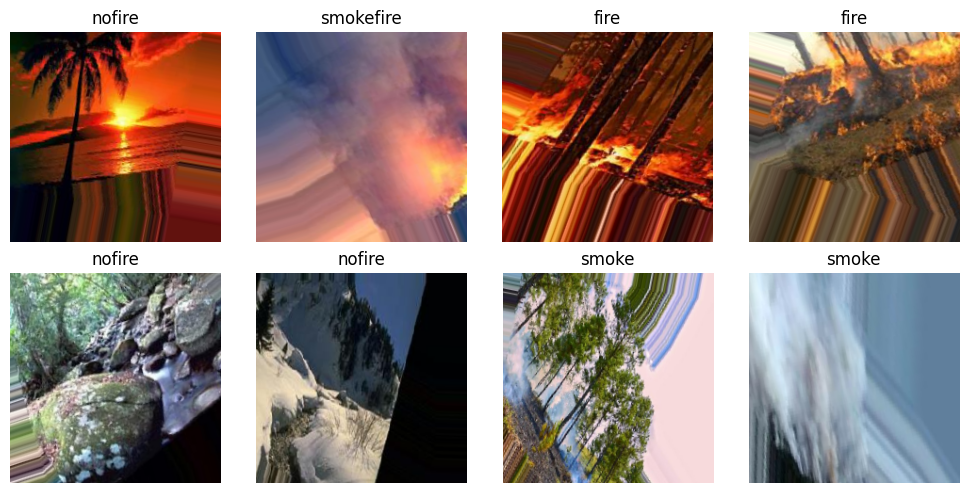

In [46]:
img_batch,label_batch=next(train_generator)
fig,axes=plt.subplots(nrows=2,ncols=4,figsize=(10,5))
axes=axes.flatten()
for i in range(8):
  axes[i].imshow(img_batch[i])
  axes[i].axis('off')
  #axes[i].set_title(f"label:{label_batch[i]}")
  class_index=np.argmax(label_batch[i])
  class_name=train_generator.class_indices
  class_name=dict((v,k)for k,v in class_name.items())
  class_name=class_name[class_index]
  axes[i].set_title(f"{class_name}")
plt.tight_layout()
plt.show()

In this the code is designed to visualize a batch of images ( first 8 images) that are being passes through train_generator and display their corresponding class labels. It visually confirms that the images are being correctly loaded, augmented and labeled.

**Summarize Dataset Information**


In [47]:

import pandas as pd # Import the pandas library and assign it the alias 'pd'

# Create a DataFrame summarizing dataset information
data_summary = pd.DataFrame({
    "Dataset": ["Train", "Validation", "Test"],
    "Total Images": [train_total, val_total, test_total],
    "Fire": [train_counts.get("fire", 0), val_counts.get("fire", 0), test_counts.get("fire", 0)],
    "No Fire": [train_counts.get("nofire", 0), val_counts.get("nofire", 0), test_counts.get("nofire", 0)],
    "Smoke": [train_counts.get("smoke", 0), val_counts.get("smoke", 0), test_counts.get("smoke", 0)],
    "Fire Smoke": [train_counts.get("smokefire", 0), val_counts.get("smokefire", 0), test_counts.get("smokefire", 0)]

})

#  Use display() to show the DataFrame in Colab
display(data_summary)


Dataset  Total Images  Fire  No Fire  Smoke  Fire Smoke
0       Train          3220   800      800    820         800
1  Validation           800   200      200    200         200
2        Test           800   200      200    200         200

All Datasets have a balanced distribution of images across the four classes . This shows that  how the data is distributed across three datasets ( training, testing and validation ).

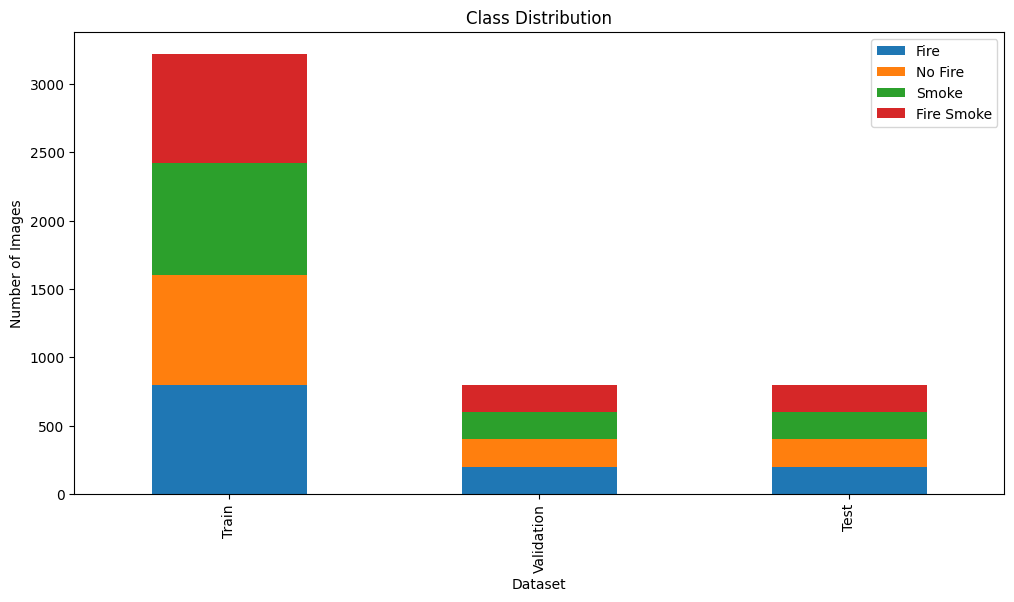

In [48]:
def plot_class_distribution(data_summary):
  data_summary.set_index("Dataset",inplace=True)
  data_summary[['Fire','No Fire',"Smoke","Fire Smoke"]].plot(kind='bar',stacked=True,figsize=(12,6))
  plt.title("Class Distribution")
  plt.xlabel("Dataset")
  plt.ylabel("Number of Images")
  plt.legend(loc='upper right')
  plt.show()

plot_class_distribution(data_summary)

**Checking if all the images have the same size or not**


In [49]:
def check_image_size(generator):
  sizes=set()
  for i in range(len(generator)):
    batch_x,batch_y=generator[i]
    for img in batch_x:
        sizes.add(img.shape[:2])
  return sizes

train_sizes=check_image_size(train_generator)
val_sizes=check_image_size(val_generator)
test_sizes=check_image_size(test_generator)
print(f"Train Image Sizes: {train_sizes}")
print(f"Validation Image Sizes: {val_sizes}")
print(f"Test Image Sizes: { test_sizes}")
if len(train_sizes)>1 or len(val_sizes)>1 or len(test_sizes)>1:
  print("All images are not having the same size")
else:
  print("All images are having the same size")

Train Image Sizes: {(224, 224)}
Validation Image Sizes: {(224, 224)}
Test Image Sizes: {(224, 224)}
All images are having the same size


All images in the dataset are having same size (224 x 224 pixels).

Since the set contains only one unique size per dataset, this confirms that all images are consistent.

**VGG16**

Loading VGG16 model pretrained on imagenet but without the top classification layers.

include_top=False - it lets us to add our own classifier.

input_shape=(224,224,3) - it ensures that our input image size matches VGG16 expectations.

Here we are freezing all layers in the base VGG16 model.
only the newly added top layers will be trained, which is efficient when the dataset is smaller.

Here we are using Dropout also to prevent overfitting by randomly dropping 50% of the neurons during training.

As we are having 4 classes our final output layer has 4 classes.

In [50]:
base_model=VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))
base_model.trainable=False
model=models.Sequential([base_model,
                         layers.GlobalAveragePooling2D(),
                         layers.Dense(128,activation='relu'),
                         layers.Dropout(0.5),
                         layers.Dense(4,activation='softmax')])

We are using Adam optimizer for adaptive learning.

Categorical crossentropy is used as the loss function as we are having multi classes.

In [51]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Training the model for 10 epochs.

In [52]:
history=model.fit(train_generator,validation_data=val_generator,epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 84s 674ms/step - accuracy: 0.4007 - loss: 1.2993 - val_accuracy: 0.7075 - val_loss: 0.9151
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 60s 591ms/step - accuracy: 0.5872 - loss: 0.9778 - val_accuracy: 0.7513 - val_loss: 0.7452
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 59s 586ms/step - accuracy: 0.6552 - loss: 0.8389 - val_accuracy: 0.7513 - val_loss: 0.6913
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 60s 591ms/step - accuracy: 0.6761 - loss: 0.7991 - val_accuracy: 0.7912 - val_loss: 0.6182
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 59s 580ms/step - accuracy: 0.7078 - loss: 0.7240 - val_accuracy: 0.7862 - val_loss: 0.5788
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 60s 591ms/step - accuracy: 0.7212 - loss: 0.7032 - val_accuracy: 0.8175 - val_loss: 0.5414
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 81s 582ms/step - accuracy: 0.7138 - loss: 0.6916 - val_accuracy: 0.8425 - val_loss: 0.5139
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 59s 584ms/step - accuracy: 0.7458 - loss: 0

Plotting the graphs how training and validation metrics evolve over epochs.

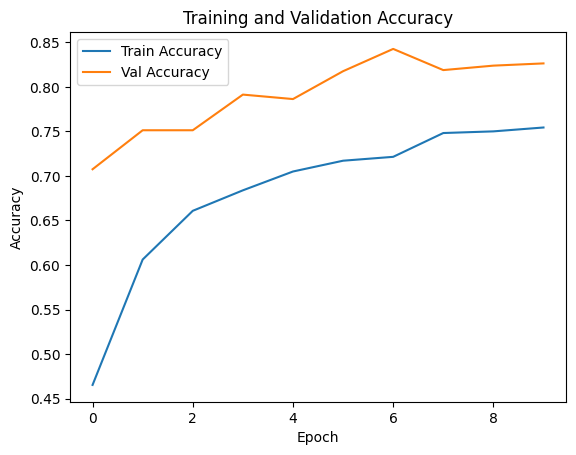

In [53]:
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Val Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

from the graph we can see that the training accuracy improves steadily. validation accuracy remains consistently higher than the training accuracy.


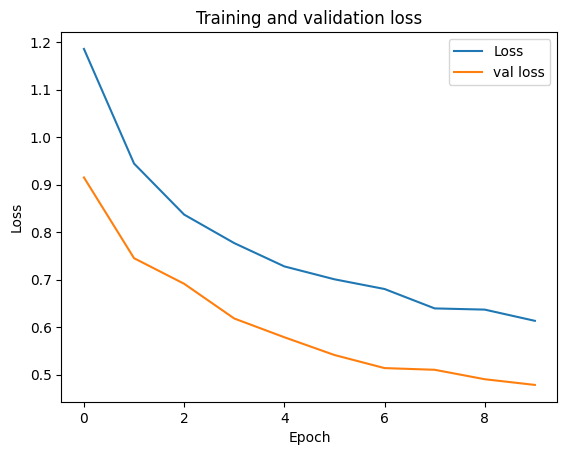

In [54]:
plt.plot(history.history["loss"],label='Loss')
plt.plot(history.history["val_loss"],label='val loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

from this graph we can see that the losses go down showing that the model is learning effectively.

val loss is lower than the training loss suggests that good generalization.

In [55]:
y_pred=model.predict(test_generator)
y_pred_classes=np.argmax(y_pred,axis=1)
y_true=test_generator.classes
class_labels=list(test_generator.class_indices.keys())
print(classification_report(y_true,y_pred_classes,target_names=class_labels))

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step
              precision    recall  f1-score   support

        fire       0.95      0.53      0.68       200
      nofire       0.84      0.97      0.90       200
       smoke       0.48      0.89      0.62       200
   smokefire       0.21      0.10      0.13       200

    accuracy                           0.62       800
   macro avg       0.62      0.62      0.58       800
weighted avg       0.62      0.62      0.58       800



From the classification report Fire class is detected well when predicted as it has high precision value, But many true fire samples are missed as Recall is low.

Nofire class is performing well as its Precision and Recall is greater than 0.9

Smoke shows high recall but low precision. Model detects many smoke instances but many are false positives.

SmokeFire is severly underperforming -it can be due to confusion with smoke or fire classes and possibly with overlap.

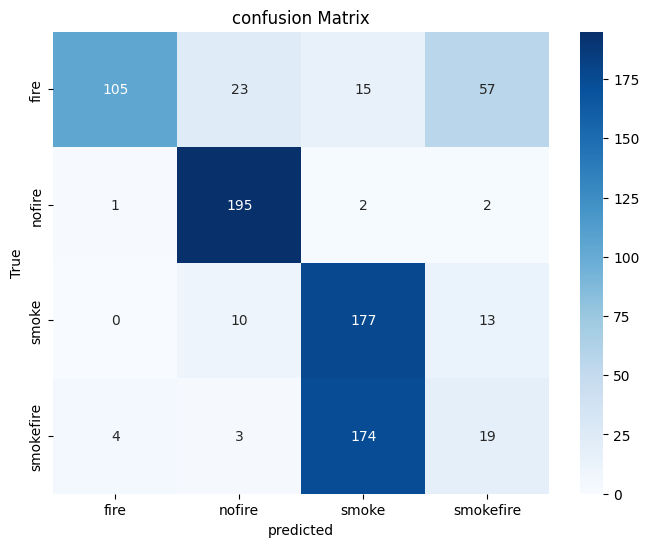

In [56]:
cm=confusion_matrix(y_true,y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=class_labels,yticklabels=class_labels)
plt.xlabel("predicted")
plt.ylabel("True")
plt.title("confusion Matrix")
plt.show()

In [57]:
x_test,y_test=next(test_generator)
class_indices=test_generator.class_indices
idx_to_label=dict((v,k)for k,v in class_indices.items())


In [58]:
preds=model.predict(x_test)
pred_classes=np.argmax(preds,axis=1)
true_classes=np.argmax(y_test,axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step


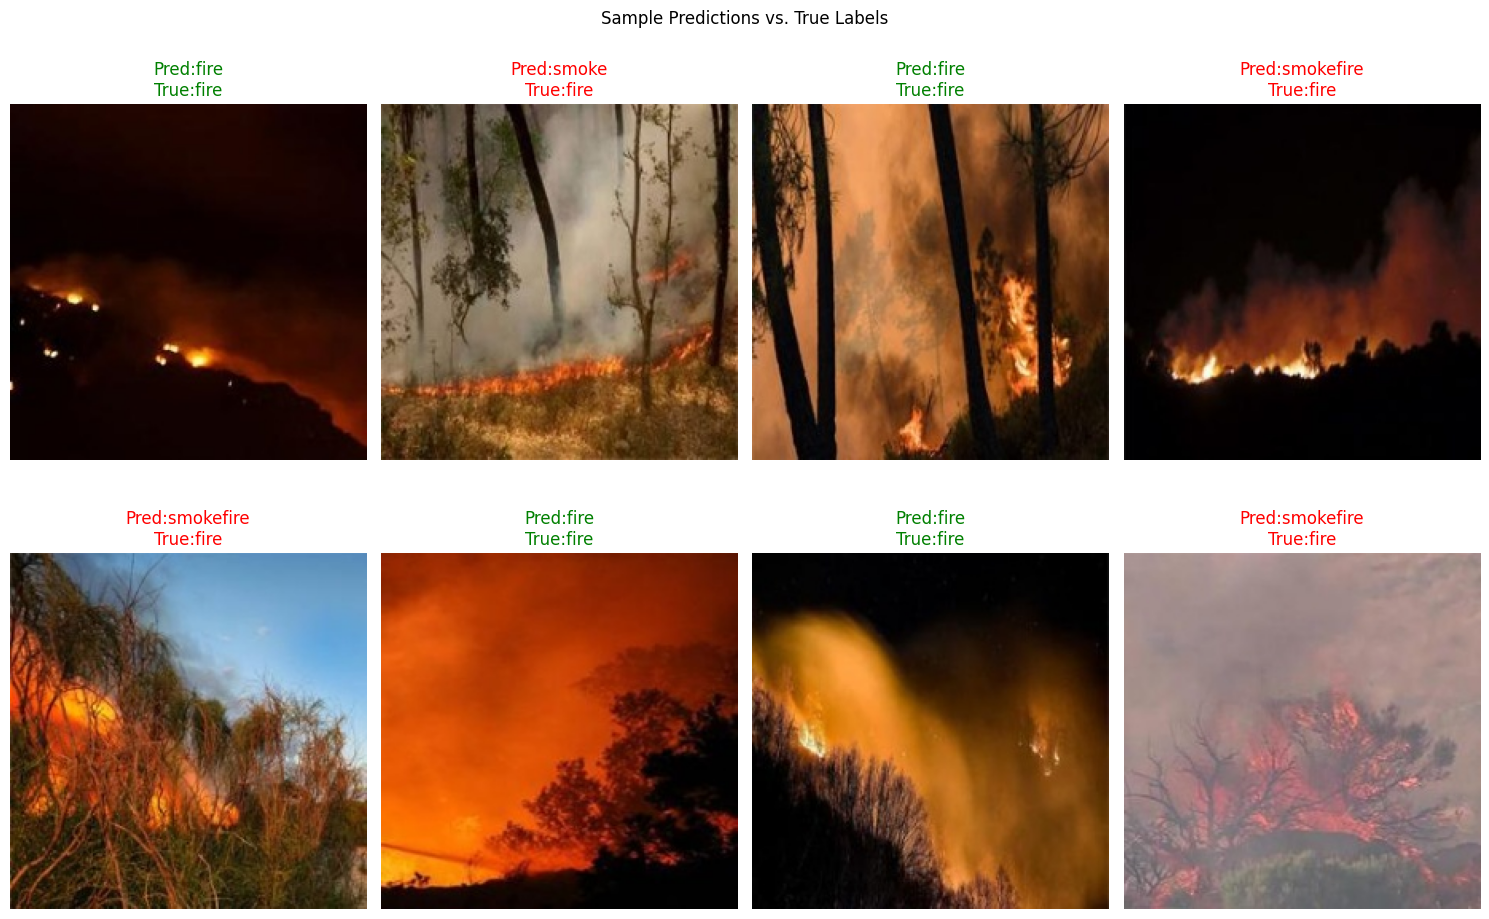

In [59]:
plt.figure(figsize=(15,10))
for i in range(8):
  plt.subplot(2,4,i+1)
  plt.imshow(x_test[i])
  plt.axis("off")
  true_label=idx_to_label[true_classes[i]]
  pred_label=idx_to_label[pred_classes[i]]
  color="green" if true_label==pred_label else 'red'
  plt.title(f"Pred:{pred_label}\nTrue:{true_label}",color=color)
plt.suptitle("Sample Predictions vs. True Labels")
plt.tight_layout()
plt.show()

Here we can see that the Green title shows correct prediction and red shows the wrong prediction.

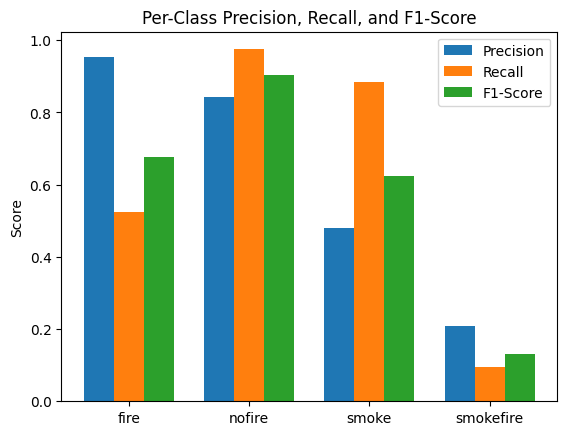

In [60]:
# Calculate class-wise metrics
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_true, y_pred_classes, average=None)
recall = recall_score(y_true, y_pred_classes, average=None)
f1 = f1_score(y_true, y_pred_classes, average=None)

# Bar chart
x = np.arange(len(class_labels))
width = 0.25

plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1-Score')
plt.xticks(x, class_labels)
plt.ylabel('Score')
plt.title('Per-Class Precision, Recall, and F1-Score')
plt.legend()
plt.show()

🔥Fire:

High Precision: 0.88 - when it predicts fire its usually correct.

Low Recall :0.59 - But it misses many actual fire images some get classified as smoke or smokefire.

🚫No Fire:

Good results across all metrics - this is the easiest class to the model to detect.

💨Smoke:

Low precision: 0.49 - it incorrectly classifies many images as smoke.

High Recall: 0.93 - It gets almost all true smoke images.

🔥💨 Fire Smoke:

Not good performance, as it is getting confused between smoke and fire. Model lacks understanding of mixed class features.

**Xception**

Loading the pretrained Xception model without the top classification layers.

In [61]:
xception_base=Xception(weights='imagenet',include_top=False,input_shape=(224,224,3))
xception_base.trainable=False

In [62]:
model_xcep=models.Sequential([xception_base,
                              layers.GlobalAveragePooling2D(),
                              layers.Dense(128,activation='relu'),
                              layers.Dropout(0.5),
                              layers.Dense(4,activation='softmax')])

In [63]:
model_xcep.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [64]:
history_xcep=model_xcep.fit(train_generator,
                            validation_data=val_generator,
                            epochs=10)

Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 77s 643ms/step - accuracy: 0.6211 - loss: 0.8609 - val_accuracy: 0.8350 - val_loss: 0.4354
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 69s 588ms/step - accuracy: 0.8034 - loss: 0.5125 - val_accuracy: 0.8500 - val_loss: 0.3827
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 58s 573ms/step - accuracy: 0.8371 - loss: 0.4397 - val_accuracy: 0.8662 - val_loss: 0.3689
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 57s 566ms/step - accuracy: 0.8258 - loss: 0.4506 - val_accuracy: 0.8675 - val_loss: 0.3499
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 58s 572ms/step - accuracy: 0.8432 - loss: 0.4161 - val_accuracy: 0.8587 - val_loss: 0.3715
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 58s 573ms/step - accuracy: 0.8387 - loss: 0.3984 - val_accuracy: 0.8750 - val_loss: 0.3324
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 57s 569ms/step - accuracy: 0.8406 - loss: 0.4093 - val_accuracy: 0.8700 - val_loss: 0.3326
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 57s 567ms/step - accuracy: 0.8635 - loss: 0

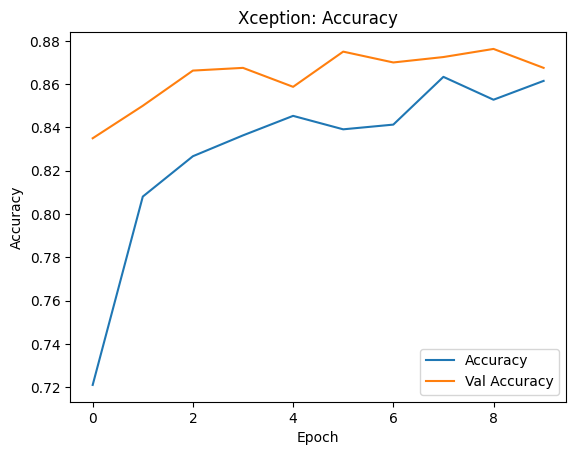

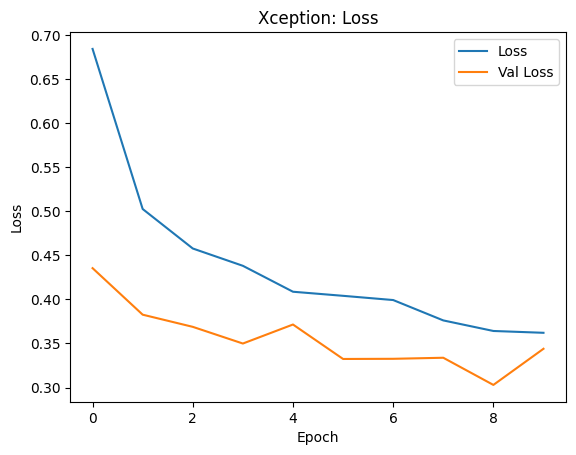

In [65]:
plt.plot(history_xcep.history['accuracy'], label='Accuracy')
plt.plot(history_xcep.history['val_accuracy'], label='Val Accuracy')
plt.title("Xception: Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history_xcep.history['loss'], label='Loss')
plt.plot(history_xcep.history['val_loss'], label='Val Loss')
plt.title("Xception: Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Accuracy Plot :

From the graphs we can see that the training accuracy starts around 70% ends around 86% and validation accuracy starts at around 83% and peaks at 88%.

* model generalizes well.
* validation accuracy remains above training accuracy shows no overfitting and suggests to fine tune by unfreeze layers.

Loss Plot:

Both training and validation loss consistently decrease. for validation the loss ends at 0.32 and for training the loss ends at 0.34.

* shows good convergence.
* No major overfitting.


In [66]:
y_pred_xcep = model_xcep.predict(test_generator)
y_pred_classes_xcep = np.argmax(y_pred_xcep, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())



25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step


In [67]:
# Classification Report
print(classification_report(y_true, y_pred_classes_xcep, target_names=class_labels))



              precision    recall  f1-score   support

        fire       0.94      0.65      0.77       200
      nofire       0.88      0.96      0.92       200
       smoke       0.61      0.85      0.71       200
   smokefire       0.53      0.43      0.48       200

    accuracy                           0.72       800
   macro avg       0.74      0.72      0.72       800
weighted avg       0.74      0.72      0.72       800



🔥Fire:

* Precision: 0.88 - when the model predicts fire it is correct 88% of the time.
* Recall : 0.71 - it identifies 71% of actual fire images.
* F1: 0.79 - good balance, though some fires are misclassified as smoke or smokefire.
* High precision, but slightly lower recall - shows model is conservative about prediction fire.

🚫No Fire:

* Precision : 0.90 , Recall : 0.95, f1-score : 0.92
* This is the best performing class.
* Most nofire images are correctly predicted and rarely confused with other classes.
* it is stable and highly reliable predictions.

💨Smoke:

* Precision : 0.61 , recall : 0.94, f1-score: 0.74
* High Recall but low precision - shows the model is over predicting smoke resulting in many false positives.
* Might be misclassifying fire and smokefire images as smoke.

🔥💨 Fire Smoke:

* Precision: 0.55, recall : 0.33, f1-score: 0.41
* This class is the weakest : only 33% of actual smokefire images are correctly identied. The rest are misclassified as smoke or fire.

The model does well on nofire and fire.

It struggles with smokefire, which is understandable due to its visual overlap with both fire and smoke.

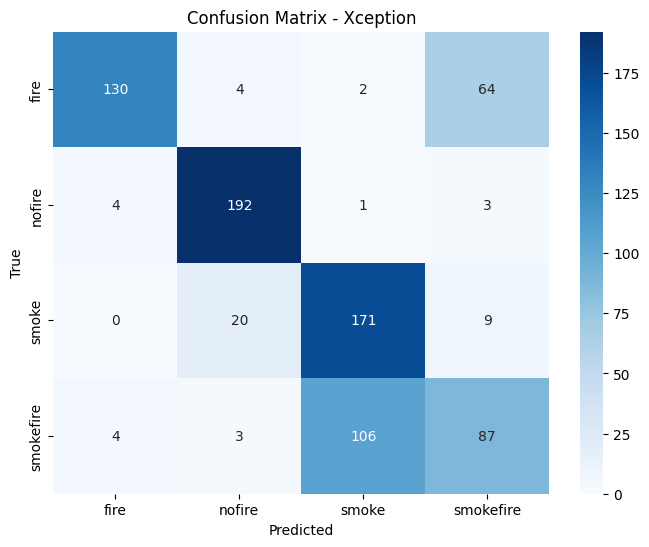

In [68]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes_xcep)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Xception")
plt.show()

In [69]:
# Load one batch from the test generator
x_test_batch, y_test_batch = next(test_generator)

# Get class label mapping
class_indices = test_generator.class_indices
idx_to_label = dict((v, k) for k, v in class_indices.items())

# Get predictions
preds = model_xcep.predict(x_test_batch)
pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(y_test_batch, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


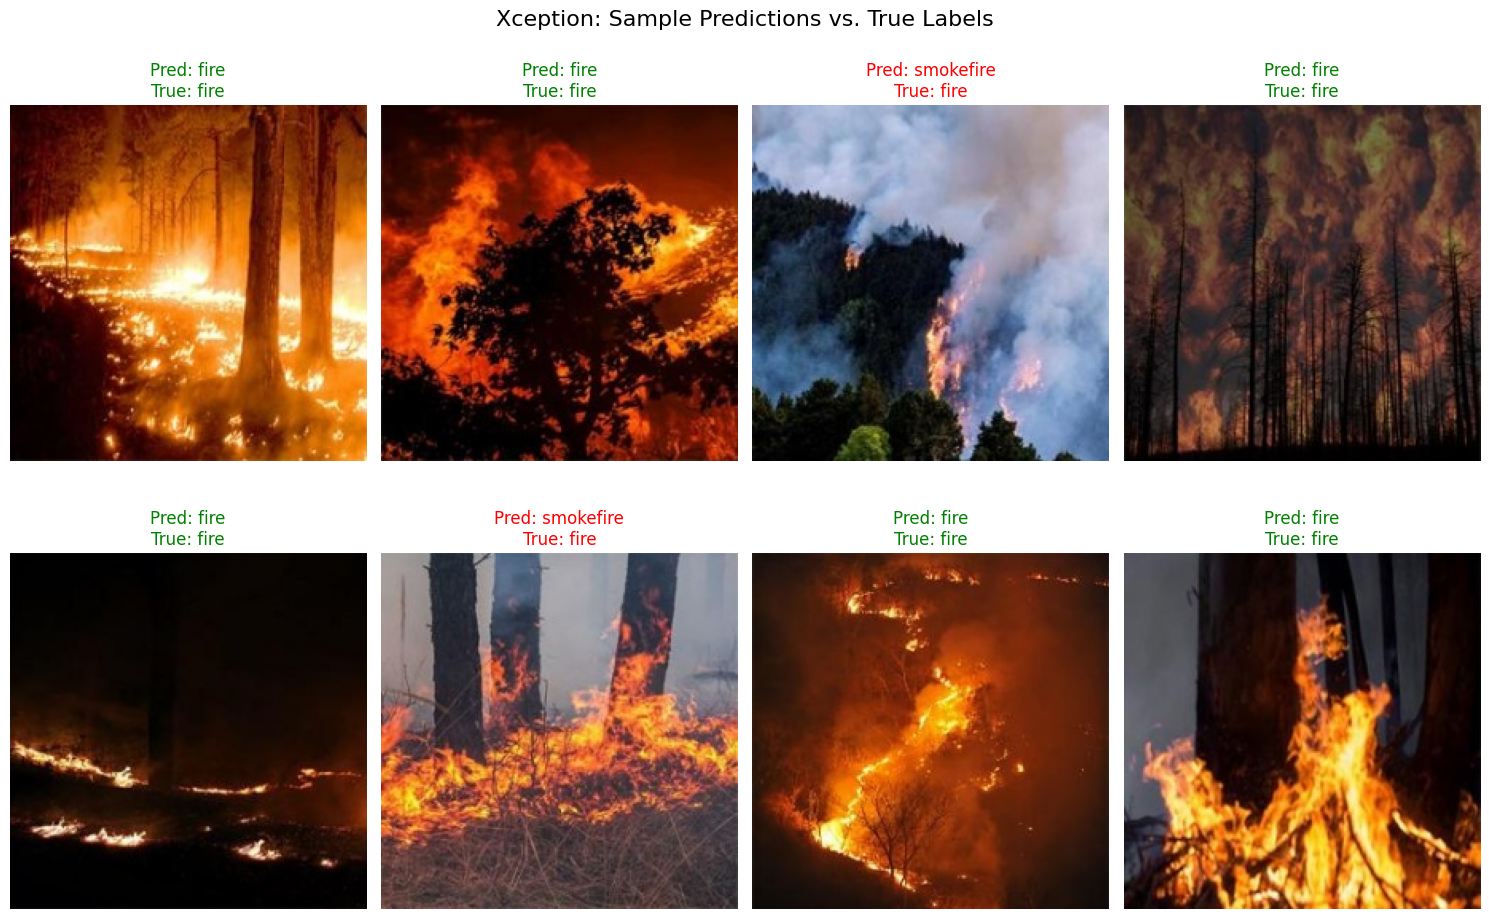

In [70]:
plt.figure(figsize=(15, 10))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(x_test_batch[i])
    plt.axis("off")
    true_label = idx_to_label[true_classes[i]]
    pred_label = idx_to_label[pred_classes[i]]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
plt.suptitle("Xception: Sample Predictions vs. True Labels", fontsize=16)
plt.tight_layout()
plt.show()


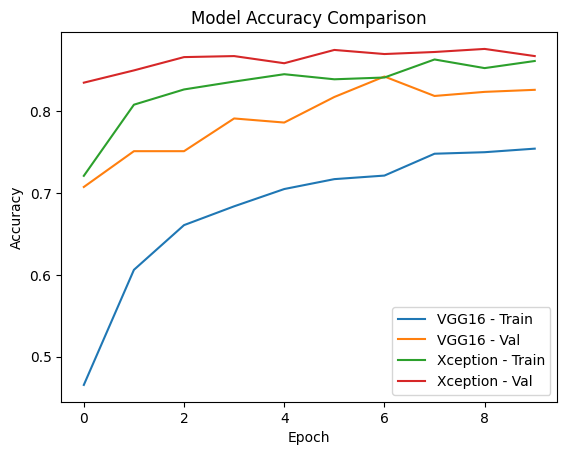

In [71]:
plt.plot(history.history['accuracy'], label='VGG16 - Train')
plt.plot(history.history['val_accuracy'], label='VGG16 - Val')
plt.plot(history_xcep.history['accuracy'], label='Xception - Train')
plt.plot(history_xcep.history['val_accuracy'], label='Xception - Val')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Xception is the better model overall.

Validation accuracy is consistently high suggesting Xception generalizes well.

VGG16 underfits slightly especially in early epochs and converges slowly.

No major overfitting in either model, which shows that the data augmentation is working well.

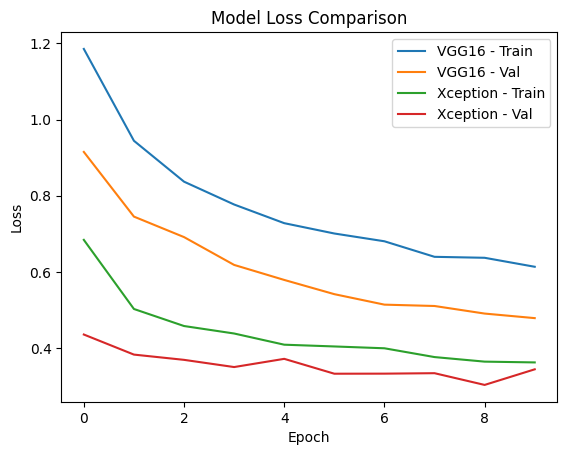

In [72]:
plt.plot(history.history['loss'], label='VGG16 - Train')
plt.plot(history.history['val_loss'], label='VGG16 - Val')
plt.plot(history_xcep.history['loss'], label='Xception - Train')
plt.plot(history_xcep.history['val_loss'], label='Xception - Val')
plt.title('Model Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


**VGG16**

* Starts with a veru high training loss (1.22) and decreases steadily to 0.61.
* Validation loss also drop from 0.93 to 0.46.
* This shows slow but stable learning.
* Final gap between train and val loss is moderate, indicating some room for improvement.

**Xception**

* Starts with much lower loss 0.70 for train and 0.45 for validation.
* Drops faster and stabilizes between 0.31 to 0.35 on both train and validation.
* No significant overfitting - validation loss closely tracks training loss.
* Final loss is clearly lower than VGG16, which means better predictive performance.


Xception converges faster and to a lower loss.

Indicates better feature extraction , fewer misclassifiations and more confident preddictions.

Very little overfitting in both models due to good augmentation and early stopping.


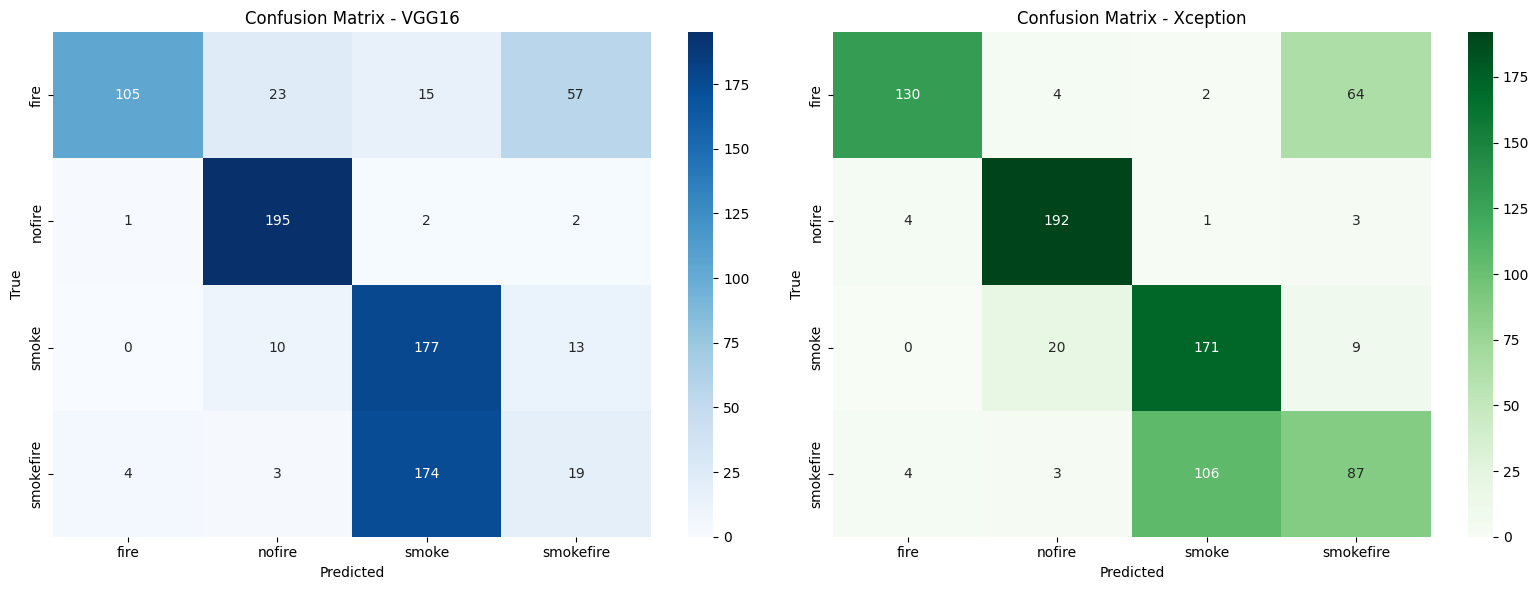

In [73]:
cm_vgg = confusion_matrix(y_true, y_pred_classes)
cm_xcep = confusion_matrix(y_true, y_pred_classes_xcep)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# VGG16
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=axes[0])
axes[0].set_title("Confusion Matrix - VGG16")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# Xception
sns.heatmap(cm_xcep, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels, ax=axes[1])
axes[1].set_title("Confusion Matrix - Xception")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()


In [74]:
from sklearn.metrics import classification_report

# Get reports as dictionaries
report_vgg = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)
report_xcep = classification_report(y_true, y_pred_classes_xcep, target_names=class_labels, output_dict=True)

# Extract macro averages
vgg_macro = report_vgg['macro avg']
xcep_macro = report_xcep['macro avg']

# Print nicely
print("VGG16 - Macro Avg:")
print(f"Precision: {vgg_macro['precision']:.4f}")
print(f"Recall:    {vgg_macro['recall']:.4f}")
print(f"F1-score:  {vgg_macro['f1-score']:.4f}")

print("\n Xception - Macro Avg:")
print(f"Precision: {xcep_macro['precision']:.4f}")
print(f"Recall:    {xcep_macro['recall']:.4f}")
print(f"F1-score:  {xcep_macro['f1-score']:.4f}")


VGG16 - Macro Avg:
Precision: 0.6221
Recall:    0.6200
F1-score:  0.5840

 Xception - Macro Avg:
Precision: 0.7408
Recall:    0.7250
F1-score:  0.7194


Here I am taking the macro average means calculating the metric independently for each class then taking the average, it treats all classes equally, regardless of the number of instances.

From all the metrics like precision , Recall and F1-score Xception model looks better than VGG16.

Initially we trained the xception model with feature extraction only by keeping xception_base.trainable=False.

Now we are unfreezing the last 30 layers of Xception allowing them to retrain and adapt to the dataset.

This is called partial fine tuning, which is a common strategy  when the dataset is relatively small and want to preserve the benefits of pretraining while specializing a portion of the network.

In [75]:
# Unfreeze the last 30 layers
xception_base.trainable = True
for layer in xception_base.layers[:-30]:
    layer.trainable = False


Lower learning rate ensures stable and gradual updates to the pretrained weights during fine tuning.

In [76]:
# Recompile the model with a low learning rate
model_xcep.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Early stopping : Stops training if validation accuracy stops improving.( patience - 3epochs)

ModelCheckpoint: Saves only the best model during training.

In [77]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint("best_xception_finetuned.h5", save_best_only=True)
]

The model is now trained further, but only the last 30 layers of Xception and the classification head are updated.

In [78]:
# Fine-tune the model
history_ft = model_xcep.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.6794 - loss: 0.8367

101/101 ━━━━━━━━━━━━━━━━━━━━ 95s 758ms/step - accuracy: 0.6798 - loss: 0.8358 - val_accuracy: 0.8475 - val_loss: 0.4302
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.7926 - loss: 0.5575

101/101 ━━━━━━━━━━━━━━━━━━━━ 118s 609ms/step - accuracy: 0.7927 - loss: 0.5571 - val_accuracy: 0.8650 - val_loss: 0.3837
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.8205 - loss: 0.4709

101/101 ━━━━━━━━━━━━━━━━━━━━ 60s 597ms/step - accuracy: 0.8207 - loss: 0.4704 - val_accuracy: 0.8788 - val_loss: 0.3507
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.8556 - loss: 0.3779

101/101 ━━━━━━━━━━━━━━━━━━━━ 83s 611ms/step - accuracy: 0.8556 - loss: 0.3778 - val_accuracy: 0.8888 - val_loss: 0.3192
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.8657 - loss: 0.3803

101/101 ━━━━━━━━━━━━━━━━━━━━ 60s 597ms/step - accuracy: 0.8656 - loss: 0.3803 - val_accuracy: 0.8913 - val_loss: 0.2912
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.8730 - loss: 0.3347

101/101 ━━━━━━━━━━━━━━━━━━━━ 61s 600ms/step - accuracy: 0.8731 - loss: 0.3347 - val_accuracy: 0.8913 - val_loss: 0.2739
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.8950 - loss: 0.2884

101/101 ━━━━━━━━━━━━━━━━━━━━ 61s 598ms/step - accuracy: 0.8949 - loss: 0.2886 - val_accuracy: 0.8925 - val_loss: 0.2725
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.8961 - loss: 0.2779

101/101 ━━━━━━━━━━━━━━━━━━━━ 61s 603ms/step - accuracy: 0.8961 - loss: 0.2779 - val_accuracy: 0.8975 - val_loss: 0.2603
Epoch 9/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.9004 - loss: 0.2759

101/101 ━━━━━━━━━━━━━━━━━━━━ 61s 598ms/step - accuracy: 0.9004 - loss: 0.2758 - val_accuracy: 0.9038 - val_loss: 0.2449
Epoch 10/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.9041 - loss: 0.2505

101/101 ━━━━━━━━━━━━━━━━━━━━ 60s 595ms/step - accuracy: 0.9041 - loss: 0.2505 - val_accuracy: 0.9062 - val_loss: 0.2275


In [79]:
# Predict on test data
y_pred_ft = model_xcep.predict(test_generator)
y_pred_classes_ft = np.argmax(y_pred_ft, axis=1)
y_true_ft = test_generator.classes
class_labels = list(test_generator.class_indices.keys())


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step


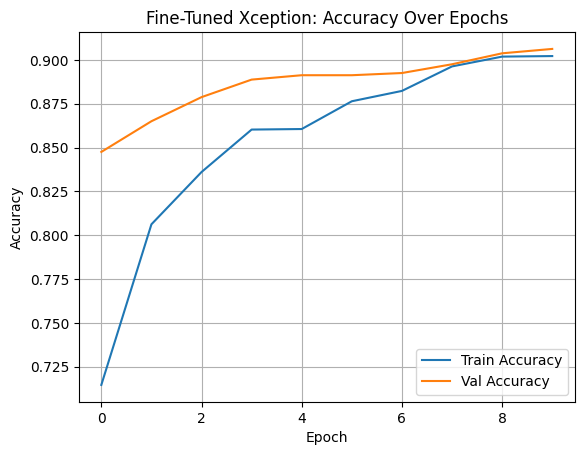

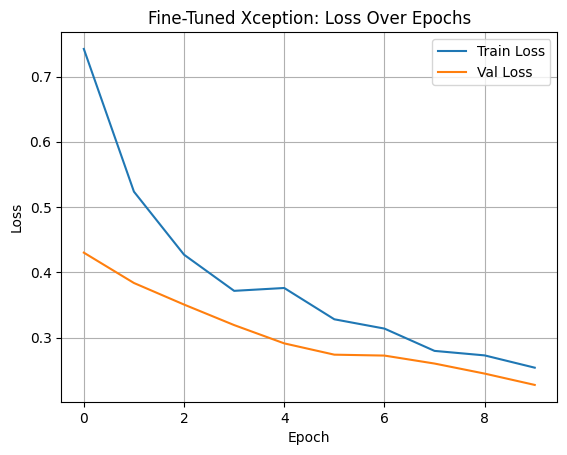

In [80]:
# Plot Accuracy
plt.plot(history_ft.history['accuracy'], label='Train Accuracy')
plt.plot(history_ft.history['val_accuracy'], label='Val Accuracy')
plt.title('Fine-Tuned Xception: Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.plot(history_ft.history['loss'], label='Train Loss')
plt.plot(history_ft.history['val_loss'], label='Val Loss')
plt.title('Fine-Tuned Xception: Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

These two plots are showing how the fine tuned Xception model performed over 10 epochs in terms of accuracy and loss.

Accuracy Plot:
* Training accuracy starts around 69% and increased steadily to 91%.
* validation accuracy starts high at 83% improves gradually, and finishes slightly above 91%.
* Both curves improves consistently with no signs of overfitting.
* The validation accuracy is consistently higher than the training accuracy shows a very good sign showing strong generalization and effective transfer learning and fine tuning.
* Early stopping might have helped in stabilize learning.

Loss plot:
* Training loss starts high at 0.8 drops sharply, and ends around 0.24.
* validation loss starts lower at 0.44 and decreases staedily to 0.23.
* Both training and validation loss decrease consistently indicating good conevrgence.




In [81]:

print("Classification Report - Fine-Tuned Xception")
print(classification_report(y_true_ft, y_pred_classes_ft, target_names=class_labels))

Classification Report - Fine-Tuned Xception
              precision    recall  f1-score   support

        fire       0.92      0.66      0.77       200
      nofire       0.98      0.97      0.98       200
       smoke       0.61      0.94      0.74       200
   smokefire       0.50      0.38      0.43       200

    accuracy                           0.74       800
   macro avg       0.75      0.74      0.73       800
weighted avg       0.75      0.74      0.73       800



Overall accuracy : accuracy is improved from 73% to 75%. after fine tuning.



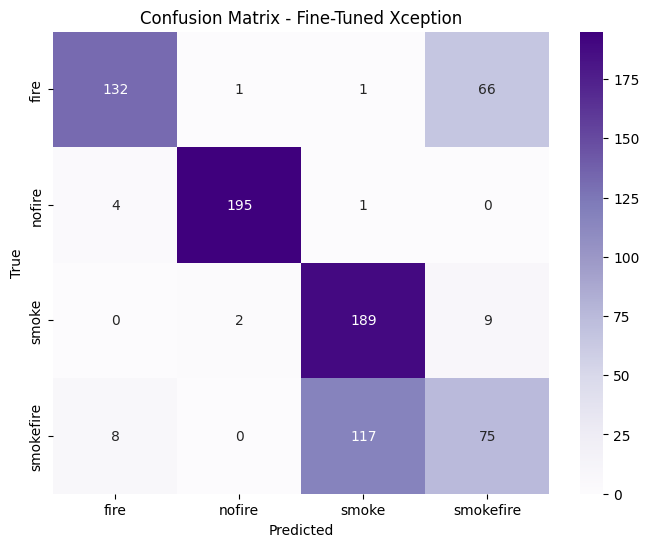

In [82]:
cm_ft = confusion_matrix(y_true_ft, y_pred_classes_ft)

plt.figure(figsize=(8,6))
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Purples', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Fine-Tuned Xception")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


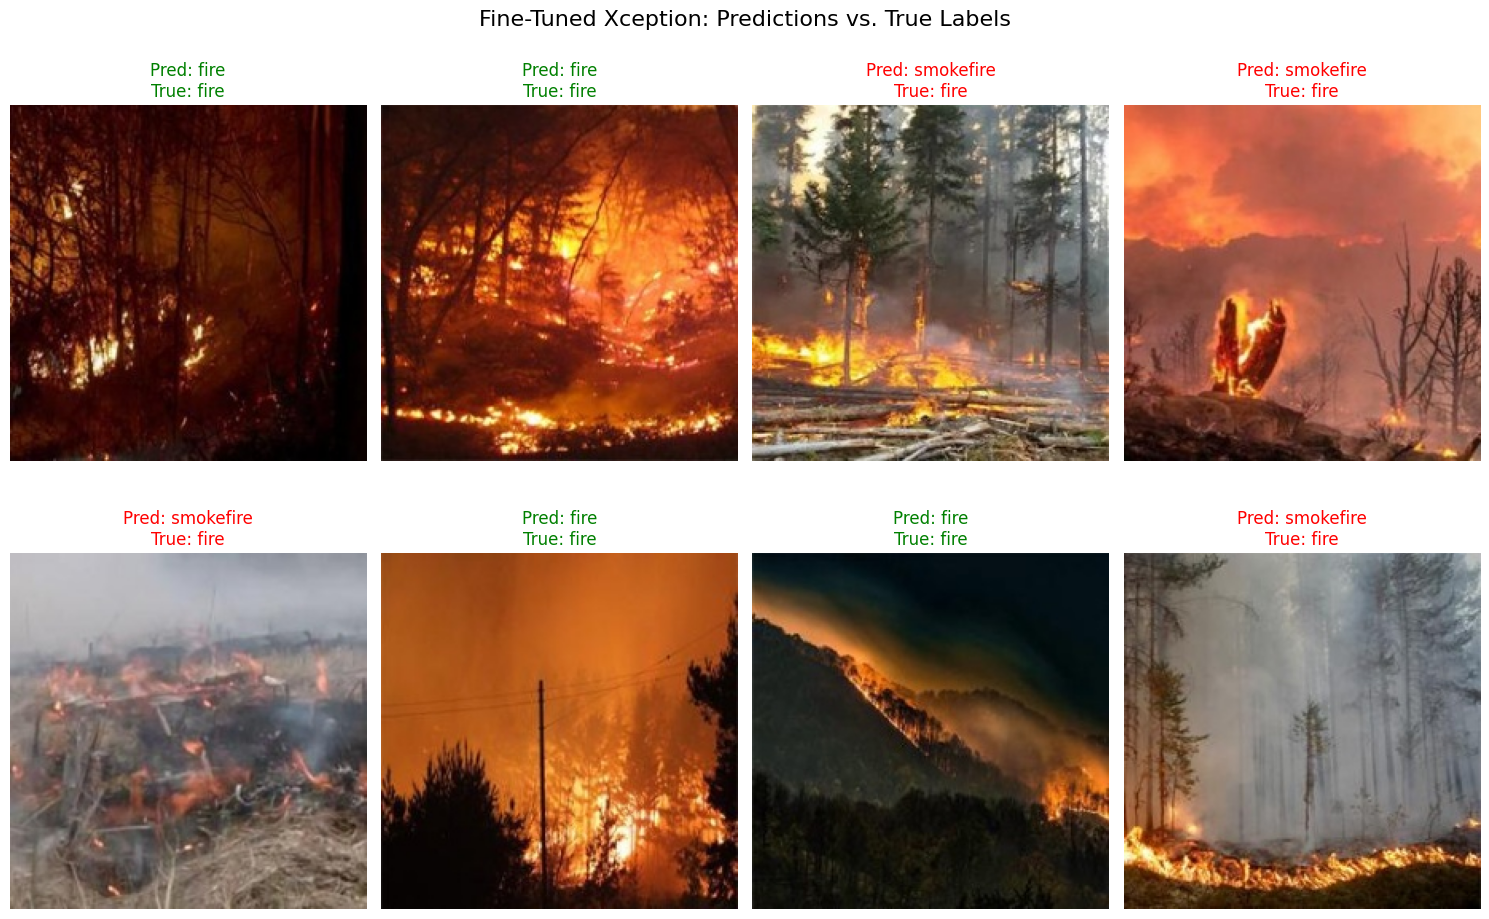

In [83]:
# Load a batch
x_test_batch_ft, y_test_batch_ft = next(test_generator)

# Convert predictions
preds_ft = model_xcep.predict(x_test_batch_ft)
pred_classes_ft = np.argmax(preds_ft, axis=1)
true_classes_ft = np.argmax(y_test_batch_ft, axis=1)
idx_to_label = {v: k for k, v in test_generator.class_indices.items()}

# Plot
plt.figure(figsize=(15, 10))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(x_test_batch_ft[i])
    plt.axis("off")
    true_label = idx_to_label[true_classes_ft[i]]
    pred_label = idx_to_label[pred_classes_ft[i]]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
plt.suptitle("Fine-Tuned Xception: Predictions vs. True Labels", fontsize=16)
plt.tight_layout()
plt.show()

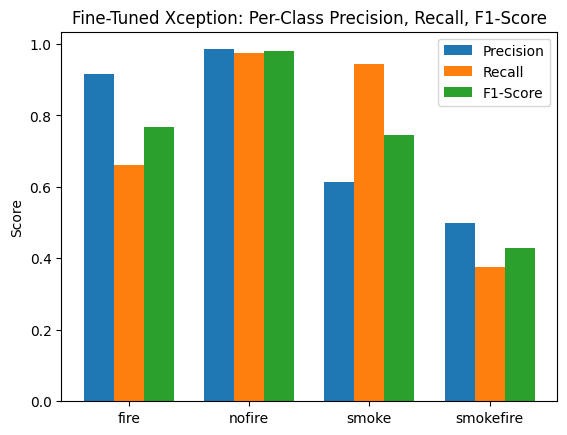

In [84]:
precision_ft = precision_score(y_true_ft, y_pred_classes_ft, average=None)
recall_ft = recall_score(y_true_ft, y_pred_classes_ft, average=None)
f1_ft = f1_score(y_true_ft, y_pred_classes_ft, average=None)

x = np.arange(len(class_labels))
width = 0.25

plt.bar(x - width, precision_ft, width, label='Precision')
plt.bar(x, recall_ft, width, label='Recall')
plt.bar(x + width, f1_ft, width, label='F1-Score')
plt.xticks(x, class_labels)
plt.ylabel('Score')
plt.title('Fine-Tuned Xception: Per-Class Precision, Recall, F1-Score')
plt.legend()
plt.show()

This bar plot shows per class precision, recall and f1 score. for the fine tuned Xception model.

Fire:
* Precision : 0.92 - when the model prdicts fire, its correct most of the time.
* Recall : 0.70 - It misses 30% of actual images.
* F1score : 0.79 - balanced but could improve recall.
* insight : model is cautious about predicting fire but accurate when it does.

Nofire:
* Precision,Recall, f1score : all are nearly 0.98 and perfect.
* insight : this is the best performing class.

Smoke:
* Precision: 0.62 - many false positives.
* Recall :0.96 - almost all actual smoke images are caught.
* f1score : 0.76 - good, but precision needs improvement.
* insight: model overpredicts smoke, possibly it could be due to confusion in fire smoke as just smoke.

Smokefire:
* Precision: 0.54 - half of the smokefire predictions are wrong.
* Recall : 0.38 - it misses over 60% of actual smokefire cases.
* f1score: 0.45 - weak overall performance.
* insight : Still most confused class. likely due to visual overlap with both smoke and fire. needs targeted improvement.

Save current Fine tune model

In [85]:
model_xcep.save("/content/teacher_model_lwf.keras")

Load the Teacher model

In [86]:
from tensorflow.keras.models import load_model

# Load teacher model
teacher_model = load_model("/content/teacher_model_lwf.keras")
teacher_model.trainable = False  # Freeze it


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 41 variables whereas the saved optimizer has 80 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [87]:
haze_train_path = '/content/gdrive/MyDrive/project data set/project/data set/dataset main/data 3/Forect Fire/Forest Fire_Dataset/Haze/train/haze'
haze_val_path = '/content/gdrive/MyDrive/project data set/project/data set/dataset main/data 3/Forect Fire/Forest Fire_Dataset/Haze/val/haze'
haze_test_path = '/content/gdrive/MyDrive/project data set/project/data set/dataset main/data 3/Forect Fire/Forest Fire_Dataset/Haze/test/haze'


In [88]:
def create_haze_df(path, label="haze"):
    image_paths = [os.path.join(path, img) for img in os.listdir(path)]
    labels = [label] * len(image_paths)
    return pd.DataFrame({'image': image_paths, 'label': labels})

train_haze_df = create_haze_df(haze_train_path)
val_haze_df = create_haze_df(haze_val_path)
test_haze_df = create_haze_df(haze_test_path)


In [89]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

haze_datagen = ImageDataGenerator(rescale=1./255)

train_haze_gen = haze_datagen.flow_from_dataframe(
    dataframe=train_haze_df,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    dtype='float32'
)

val_haze_gen = haze_datagen.flow_from_dataframe(
    dataframe=val_haze_df,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    dtype='float32'
)


Found 702 validated image filenames belonging to 1 classes.
Found 150 validated image filenames belonging to 1 classes.


In [90]:
print("Haze generator classes:", train_haze_gen.class_indices)


Haze generator classes: {'haze': 0}


In [91]:
def lwf_loss_binary(y_true, y_pred, teacher_pred, alpha=0.5, temperature=2.0):
    ce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)

    # 🚨 Reduce 5-class logits from teacher into a pseudo-binary score
    teacher_soft_binary = tf.reduce_mean(teacher_pred, axis=-1, keepdims=True)

    distil_loss = tf.keras.losses.binary_crossentropy(teacher_soft_binary, y_pred)

    return tf.reduce_mean(alpha * ce_loss + (1 - alpha) * distil_loss)



# Custom Keras model for LwF
class LwFModel(tf.keras.Model):
    def __init__(self, student_model, teacher_model, alpha=0.5, temperature=2.0):
        super().__init__()
        self.student = student_model
        self.teacher = teacher_model
        self.alpha = alpha
        self.temperature = temperature

    def compile(self, optimizer, loss, metrics=None, **kwargs):
        super().compile(optimizer=optimizer, loss=loss, metrics=metrics, **kwargs)
        self.my_metrics = metrics or []

    def train_step(self, data):
        x, y_true = data
        teacher_logits = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            y_pred = self.student(x, training=True)
            loss = lwf_loss_binary(y_true, y_pred, teacher_logits, self.alpha, self.temperature)

        grads = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))

        for metric in self.metrics:
            metric.update_state(y_true, y_pred)

        return {"loss": loss, **{m.name: m.result() for m in self.metrics}}

    def call(self, x):
        return self.student(x)


In [92]:
# Clone base model from previously fine-tuned Xception
base = model_xcep.layers[0]
base.trainable = False  # Optional: freeze if only using haze

student_model_haze = tf.keras.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Only 1 class
])


In [93]:
lwf_model_haze = LwFModel(student_model_haze, teacher_model, alpha=0.5, temperature=2.0)

lwf_model_haze.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)



In [94]:
history_haze = lwf_model_haze.fit(
    train_haze_gen,
    validation_data=val_haze_gen,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("lwf_haze_only.keras", save_best_only=True)
    ]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - binary_accuracy: 0.2407 - loss: 1.0000 - val_binary_accuracy: 0.3133 - val_loss: 0.7189
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 403ms/step - binary_accuracy: 0.4779 - loss: 1.0000 - val_binary_accuracy: 0.7933 - val_loss: 0.6521
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - binary_accuracy: 0.7113 - loss: 1.0000 - val_binary_accuracy: 0.9533 - val_loss: 0.6045
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 393ms/step - binary_accuracy: 0.8543 - loss: 1.0000 - val_binary_accuracy: 0.9867 - val_loss: 0.5760
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 407ms/step - binary_accuracy: 0.8867 - loss: 1.0000 - val_binary_accuracy: 1.0000 - val_loss: 0.5570
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 358ms/step - binary_accuracy: 0.9188 - loss: 1.0000 - val_binary_accuracy: 1.0000 - val_loss: 0.5410
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 377ms/step - binary_accuracy: 0.9165 - loss: 1.0000 - val_binary_accuracy: 1.0000 - val_loss: 0.5339
Epoch 8/

In [95]:
## set train, validation, and test paths
train_path = '/content/gdrive/MyDrive/project data set/project/data set/dataset main/data 3/Forect Fire/Forest Fire_Dataset/train'
validation_path = '/content/gdrive/MyDrive/project data set/project/data set/dataset main/data 3/Forect Fire/Forest Fire_Dataset/val'
test_path = '/content/gdrive/MyDrive/project data set/project/data set/dataset main/data 3/Forect Fire/Forest Fire_Dataset/test'

In [96]:
import pandas as pd
import os

def create_dataset_df(base_dir):
    image_paths, labels = [], []
    for class_label in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, class_label)
        if os.path.isdir(class_dir):
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif')):
                    image_paths.append(os.path.join(class_dir, img_file))
                    labels.append(class_label)
    return pd.DataFrame({'image': image_paths, 'label': labels})


In [97]:
train_df_5 = create_dataset_df(train_path)
val_df_5 = create_dataset_df(validation_path)
test_df_5 = create_dataset_df(test_path)

print("Train:", train_df_5['label'].value_counts())
print("Val:", val_df_5['label'].value_counts())
print("Test:", test_df_5['label'].value_counts())


Train: label
smoke        820
fire         800
nofire       800
smokefire    800
Name: count, dtype: int64
Val: label
nofire       200
smokefire    200
fire         200
smoke        200
Name: count, dtype: int64
Test: label
fire         200
nofire       200
smoke        200
smokefire    200
Name: count, dtype: int64


In [134]:
train_df_5 = pd.concat([train, train_haze_df], ignore_index=True)
val_df_5 = pd.concat([val, val_haze_df], ignore_index=True)
test_df_5 = pd.concat([test, test_haze_df], ignore_index=True)


In [135]:
train_df_5 = train_df_5.sample(frac=1, random_state=42).reset_index(drop=True)
val_df_5 = val_df_5.sample(frac=1, random_state=42).reset_index(drop=True)
test_df_5 = test_df_5.sample(frac=1, random_state=42).reset_index(drop=True)

In [136]:
# Class distribution
train_dist = train_df_5['label'].value_counts()
val_dist = val_df_5['label'].value_counts()
test_dist = test_df_5['label'].value_counts()

In [138]:
print("Train Distribution:")
print(train_dist)
print("\nValidation Distribution:")
print(val_dist)
print("\nTest Distribution:")
print(test_dist)

Train Distribution:
label
smoke        820
smokefire    800
fire         800
nofire       800
haze         702
Name: count, dtype: int64

Validation Distribution:
label
nofire       200
smoke        200
fire         200
smokefire    200
haze         150
Name: count, dtype: int64

Test Distribution:
label
fire         200
smokefire    200
smoke        200
nofire       200
haze         150
Name: count, dtype: int64


In [139]:
datagen_5class = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen_5 = ImageDataGenerator(rescale=1./255)

train_gen_5 = datagen_5class.flow_from_dataframe(
    train_df_5,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_gen_5 = val_test_datagen_5.flow_from_dataframe(
    val_df_5,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_gen_5 = val_test_datagen_5.flow_from_dataframe(
    test_df_5,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 3922 validated image filenames belonging to 5 classes.
Found 950 validated image filenames belonging to 5 classes.
Found 950 validated image filenames belonging to 5 classes.


In [142]:
def lwf_loss_multiclass(y_true, y_pred, teacher_pred, alpha=0.5, temperature=2.0):
    y_pred_soft = tf.nn.softmax(y_pred / temperature)
    teacher_soft = tf.nn.softmax(teacher_pred / temperature)

    ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    distil_loss = tf.keras.losses.KLDivergence()(teacher_soft, y_pred_soft)

    return tf.reduce_mean(alpha * ce_loss + (1 - alpha) * (temperature ** 2) * distil_loss)


In [143]:
class LwFModel(tf.keras.Model):
    def __init__(self, student_model, teacher_model, alpha=0.5, temperature=2.0):
        super().__init__()
        self.student = student_model
        self.teacher = teacher_model
        self.alpha = alpha
        self.temperature = temperature

    def compile(self, optimizer, loss, metrics=None, **kwargs):
        super().compile(optimizer=optimizer, loss=loss, metrics=metrics, **kwargs)
        self.my_metrics = metrics or []

    def train_step(self, data):
        x, y_true = data
        teacher_logits = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            y_pred = self.student(x, training=True)
            loss = lwf_loss_multiclass(y_true, y_pred, teacher_logits, self.alpha, self.temperature)
        grads = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))

        for metric in self.metrics:
            metric.update_state(y_true, y_pred)

        return {"loss": loss, **{m.name: m.result() for m in self.metrics}}

    def call(self, x):
        return self.student(x)


In [146]:
from tensorflow.keras.applications import Xception

# Step 1: Use the same base model as student
base_model_5 = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_5.trainable = False

# Step 2: Add your classification head for 5 classes
teacher_model_5 = tf.keras.Sequential([
    base_model_5,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

In [147]:
# Step 3: Compile
teacher_model_5.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [148]:
# Step 4: Train on full 5-class dataset
history_teacher_5 = teacher_model_5.fit(
    train_gen_5,
    validation_data=val_gen_5,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("teacher_model_5.keras", save_best_only=True)
    ]
)

Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 98s 723ms/step - accuracy: 0.5879 - loss: 0.9740 - val_accuracy: 0.8495 - val_loss: 0.4231
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 80s 648ms/step - accuracy: 0.8195 - loss: 0.4759 - val_accuracy: 0.8537 - val_loss: 0.3858
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 76s 614ms/step - accuracy: 0.8234 - loss: 0.4454 - val_accuracy: 0.8674 - val_loss: 0.3678
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 84s 630ms/step - accuracy: 0.8497 - loss: 0.3987 - val_accuracy: 0.8653 - val_loss: 0.3255
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 81s 620ms/step - accuracy: 0.8617 - loss: 0.3841 - val_accuracy: 0.8789 - val_loss: 0.3053
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 78s 592ms/step - accuracy: 0.8725 - loss: 0.3420 - val_accuracy: 0.8916 - val_loss: 0.3044
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 73s 587ms/step - accuracy: 0.8585 - loss: 0.3693 - val_accuracy: 0.8726 - val_loss: 0.3640
Epoch 8/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 73s 593ms/step - accuracy: 0.8687 - loss: 0

In [149]:
# Load the trained teacher model
teacher_model_5_loaded = tf.keras.models.load_model("teacher_model_5.keras")
teacher_model_5_loaded.trainable = False

# Clone the base model again for student (or reuse)
base_model_student_5 = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_student_5.trainable = False

student_model_5 = tf.keras.Sequential([
    base_model_student_5,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])


In [150]:
# Define multiclass LwF loss
def lwf_loss_multiclass(y_true, y_pred, teacher_pred, alpha=0.5, temperature=2.0):
    teacher_soft = tf.nn.softmax(teacher_pred / temperature)
    y_pred_soft = tf.nn.softmax(y_pred / temperature)
    ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    distil_loss = tf.keras.losses.KLDivergence()(teacher_soft, y_pred_soft)
    return tf.reduce_mean(alpha * ce_loss + (1 - alpha) * (temperature ** 2) * distil_loss)

# Custom LwF wrapper (reusing your existing class)
lwf_model_5 = LwFModel(student_model_5, teacher_model_5_loaded, alpha=0.5, temperature=2.0)

lwf_model_5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)



In [ ]:
# Train the student
history_lwf_5 = lwf_model_5.fit(
    train_gen_5,
    validation_data=val_gen_5,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("lwf_final_5class_model.keras", save_best_only=True)
    ]
)

Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 97s 704ms/step - categorical_accuracy: 0.2265 - loss: 0.2087 - val_categorical_accuracy: 0.4021 - val_loss: 1.4657
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 80s 645ms/step - categorical_accuracy: 0.3427 - loss: 0.2394 - val_categorical_accuracy: 0.5547 - val_loss: 1.3565
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 80s 646ms/step - categorical_accuracy: 0.4297 - loss: 0.2656 - val_categorical_accuracy: 0.6358 - val_loss: 1.2595
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 81s 635ms/step - categorical_accuracy: 0.5063 - loss: 0.3018 - val_categorical_accuracy: 0.6958 - val_loss: 1.1713
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 78s 636ms/step - categorical_accuracy: 0.5413 - loss: 0.3259 - val_categorical_accuracy: 0.7168 - val_loss: 1.0917
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 78s 630ms/step - categorical_accuracy: 0.5916 - loss: 0.3576 - val_categorical_accuracy: 0.7400 - val_loss: 1.0200
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 82s 637ms/step - categorical_a

In [144]:
'''base_5 = model_xcep.layers[0]  # Reuse pretrained base
base_5.trainable = False

student_model_5 = tf.keras.Sequential([
    base_5,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # Now 5 classes
])
'''

In [145]:
lwf_model_5 = LwFModel(student_model_5, teacher_model, alpha=0.5, temperature=2.0)

lwf_model_5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

history_5 = lwf_model_5.fit(
    train_gen_5,
    validation_data=val_gen_5,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("lwf_five_class_model.keras", save_best_only=True)
    ]
)


Epoch 1/10


ValueError: Dimensions must be equal, but are 4 and 5 for '{{node kl_divergence/truediv}} = RealDiv[T=DT_FLOAT](kl_divergence/clip_by_value, kl_divergence/clip_by_value_1)' with input shapes: [?,4], [?,5].

In [98]:
'''train_path = '/content/gdrive/MyDrive/6211/project/Forest Fire_Dataset/train'
validation_path = '/content/gdrive/MyDrive/6211/project/Forest Fire_Dataset/val'
test_path = '/content/gdrive/MyDrive/6211/project/Forest Fire_Dataset/test' '''

"train_path = '/content/gdrive/MyDrive/6211/project/Forest Fire_Dataset/train'\nvalidation_path = '/content/gdrive/MyDrive/6211/project/Forest Fire_Dataset/val'\ntest_path = '/content/gdrive/MyDrive/6211/project/Forest Fire_Dataset/test' "

In [99]:
'''import pandas as pd
import os

def create_dataset_df(base_dir):
    image_paths, labels = [], []
    for class_label in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, class_label)
        if os.path.isdir(class_dir):
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif')):
                    image_paths.append(os.path.join(class_dir, img_file))
                    labels.append(class_label)
    return pd.DataFrame({'image': image_paths, 'label': labels})'''


"import pandas as pd\nimport os\n\ndef create_dataset_df(base_dir):\n    image_paths, labels = [], []\n    for class_label in os.listdir(base_dir):\n        class_dir = os.path.join(base_dir, class_label)\n        if os.path.isdir(class_dir):\n            for img_file in os.listdir(class_dir):\n                if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif')):\n                    image_paths.append(os.path.join(class_dir, img_file))\n                    labels.append(class_label)\n    return pd.DataFrame({'image': image_paths, 'label': labels})"

In [100]:
'''train_df_5 = create_dataset_df(train_path)
val_df_5 = create_dataset_df(validation_path)
test_df_5 = create_dataset_df(test_path)

print("Train:", train_df_5['label'].value_counts())
print("Val:", val_df_5['label'].value_counts())
print("Test:", test_df_5['label'].value_counts())'''


'train_df_5 = create_dataset_df(train_path)\nval_df_5 = create_dataset_df(validation_path)\ntest_df_5 = create_dataset_df(test_path)\n\nprint("Train:", train_df_5[\'label\'].value_counts())\nprint("Val:", val_df_5[\'label\'].value_counts())\nprint("Test:", test_df_5[\'label\'].value_counts())'

In [101]:
'''from tensorflow.keras.models import clone_model
from tensorflow.keras import Sequential

# Clone the Xception base model (without classifier)
xception_base = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
xception_base.trainable = False  # Freeze base for now

# Create new student model with 5 output classes
student_model = Sequential([
    xception_base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')  # ✅ output 5 classes
])
'''

"from tensorflow.keras.models import clone_model\nfrom tensorflow.keras import Sequential\n\n# Clone the Xception base model (without classifier)\nxception_base = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))\nxception_base.trainable = False  # Freeze base for now\n\n# Create new student model with 5 output classes\nstudent_model = Sequential([\n    xception_base,\n    tf.keras.layers.GlobalAveragePooling2D(),\n    tf.keras.layers.Dense(128, activation='relu'),\n    tf.keras.layers.Dropout(0.5),\n    tf.keras.layers.Dense(5, activation='softmax')  # ✅ output 5 classes\n])\n"

In [102]:
'''lwf_model_haze = LwFModel(student_model, teacher_model, alpha=0.5, temperature=2.0)

lwf_model_haze.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)
'''

'lwf_model_haze = LwFModel(student_model, teacher_model, alpha=0.5, temperature=2.0)\n\nlwf_model_haze.compile(\n    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),\n    loss=tf.keras.losses.CategoricalCrossentropy(),\n    metrics=[tf.keras.metrics.CategoricalAccuracy()]\n)\n'

In [103]:
'''history_haze = lwf_model_haze.fit(
    train_haze_gen,
    validation_data=val_haze_gen,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("lwf_haze_only.keras", save_best_only=True)
    ]
)
'''

'history_haze = lwf_model_haze.fit(\n    train_haze_gen,\n    validation_data=val_haze_gen,\n    epochs=10,\n    callbacks=[\n        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),\n        tf.keras.callbacks.ModelCheckpoint("lwf_haze_only.keras", save_best_only=True)\n    ]\n)\n'

In [104]:
'''from tensorflow.keras.preprocessing.image import ImageDataGenerator

haze_datagen = ImageDataGenerator(rescale=1./255)

train_haze_gen = haze_datagen.flow_from_dataframe(
    dataframe=train_haze_df,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
val_haze_gen = haze_datagen.flow_from_dataframe(
    dataframe=val_haze_df,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)'''

"from tensorflow.keras.preprocessing.image import ImageDataGenerator\n\nhaze_datagen = ImageDataGenerator(rescale=1./255)\n\ntrain_haze_gen = haze_datagen.flow_from_dataframe(\n    dataframe=train_haze_df,\n    x_col='image',\n    y_col='label',\n    target_size=(224, 224),\n    batch_size=32,\n    class_mode='categorical'\n)\nval_haze_gen = haze_datagen.flow_from_dataframe(\n    dataframe=val_haze_df,\n    x_col='image',\n    y_col='label',\n    target_size=(224, 224),\n    batch_size=32,\n    class_mode='categorical'\n)"

In [105]:
'''import tensorflow as tf

def lwf_loss(y_true, y_pred, teacher_pred, alpha=0.5, temperature=2.0):
    # Ensure logits have same shape
    y_pred_soft = tf.nn.softmax(y_pred / temperature)
    teacher_pred_soft = tf.nn.softmax(teacher_pred / temperature)

    # Cross entropy loss (returns [batch_size])
    ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

    # KL divergence (returns scalar — but we scale it manually)
    distil_loss = tf.keras.losses.KLDivergence()(teacher_pred_soft, y_pred_soft)

    # Final combined loss (make sure ce_loss is reduced before adding)
    return tf.reduce_mean(alpha * ce_loss + (1 - alpha) * (temperature ** 2) * distil_loss)
'''


'import tensorflow as tf\n\ndef lwf_loss(y_true, y_pred, teacher_pred, alpha=0.5, temperature=2.0):\n    # Ensure logits have same shape\n    y_pred_soft = tf.nn.softmax(y_pred / temperature)\n    teacher_pred_soft = tf.nn.softmax(teacher_pred / temperature)\n\n    # Cross entropy loss (returns [batch_size])\n    ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)\n\n    # KL divergence (returns scalar — but we scale it manually)\n    distil_loss = tf.keras.losses.KLDivergence()(teacher_pred_soft, y_pred_soft)\n\n    # Final combined loss (make sure ce_loss is reduced before adding)\n    return tf.reduce_mean(alpha * ce_loss + (1 - alpha) * (temperature ** 2) * distil_loss)\n'

In [106]:
'''class LwFModel(tf.keras.Model):
    def __init__(self, student_model, teacher_model, alpha=0.5, temperature=2.0):
        super().__init__()
        self.student = student_model
        self.teacher = teacher_model
        self.alpha = alpha
        self.temperature = temperature

    def compile(self, optimizer, loss, metrics=None, **kwargs):
      super().compile(optimizer=optimizer, loss=loss, metrics=metrics, **kwargs)
      self.my_metrics = metrics or []
    def train_step(self, data):
      x, y_true = data
      teacher_logits = self.teacher(x, training=False)

      with tf.GradientTape() as tape:
        y_pred = self.student(x, training=True)
        loss = lwf_loss(y_true, y_pred, teacher_logits, self.alpha, self.temperature)

      grads = tape.gradient(loss, self.student.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))

      # ✅ Properly update each metric manually
      for metric in self.metrics:
        metric.update_state(y_true, y_pred)

      # ✅ Return dictionary of metric results
      return {"loss": loss, **{m.name: m.result() for m in self.metrics}}

    def call(self, x):
        return self.student(x)
'''

'class LwFModel(tf.keras.Model):\n    def __init__(self, student_model, teacher_model, alpha=0.5, temperature=2.0):\n        super().__init__()\n        self.student = student_model\n        self.teacher = teacher_model\n        self.alpha = alpha\n        self.temperature = temperature\n\n    def compile(self, optimizer, loss, metrics=None, **kwargs):\n      super().compile(optimizer=optimizer, loss=loss, metrics=metrics, **kwargs)\n      self.my_metrics = metrics or []\n    def train_step(self, data):\n      x, y_true = data\n      teacher_logits = self.teacher(x, training=False)\n\n      with tf.GradientTape() as tape:\n        y_pred = self.student(x, training=True)\n        loss = lwf_loss(y_true, y_pred, teacher_logits, self.alpha, self.temperature)\n\n      grads = tape.gradient(loss, self.student.trainable_variables)\n      self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))\n\n      # ✅ Properly update each metric manually\n      for metric in self.met

In [107]:
'''# Clone student model (same as Xception base)
student_model = tf.keras.models.clone_model(model_xcep)
student_model.set_weights(model_xcep.get_weights())

# Wrap it in our custom LwF model
lwf_model = LwFModel(student_model, teacher_model, alpha=0.5, temperature=2.0)

# Compile it
lwf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)
# Train it
history_lwf = lwf_model.fit(train_generator,
                            validation_data=val_generator,
                            epochs=10)
'''

'# Clone student model (same as Xception base)\nstudent_model = tf.keras.models.clone_model(model_xcep)\nstudent_model.set_weights(model_xcep.get_weights())\n\n# Wrap it in our custom LwF model\nlwf_model = LwFModel(student_model, teacher_model, alpha=0.5, temperature=2.0)\n\n# Compile it\nlwf_model.compile(\n    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),\n    loss=tf.keras.losses.CategoricalCrossentropy(),\n    metrics=[tf.keras.metrics.CategoricalAccuracy()]\n)\n# Train it\nhistory_lwf = lwf_model.fit(train_generator,\n                            validation_data=val_generator,\n                            epochs=10)\n'

In [108]:
'''# Evaluate on test data
y_pred_lwf = lwf_model.predict(test_generator)
y_pred_classes_lwf = np.argmax(y_pred_lwf, axis=1)
y_true_lwf = test_generator.classes

# Report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true_lwf, y_pred_classes_lwf, target_names=class_labels))

# Confusion matrix
cm_lwf = confusion_matrix(y_true_lwf, y_pred_classes_lwf)
plt.figure(figsize=(8,6))
sns.heatmap(cm_lwf, annot=True, fmt='d', cmap='coolwarm', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - LwF Xception")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
'''

'# Evaluate on test data\ny_pred_lwf = lwf_model.predict(test_generator)\ny_pred_classes_lwf = np.argmax(y_pred_lwf, axis=1)\ny_true_lwf = test_generator.classes\n\n# Report\nfrom sklearn.metrics import classification_report, confusion_matrix\nprint(classification_report(y_true_lwf, y_pred_classes_lwf, target_names=class_labels))\n\n# Confusion matrix\ncm_lwf = confusion_matrix(y_true_lwf, y_pred_classes_lwf)\nplt.figure(figsize=(8,6))\nsns.heatmap(cm_lwf, annot=True, fmt=\'d\', cmap=\'coolwarm\', xticklabels=class_labels, yticklabels=class_labels)\nplt.title("Confusion Matrix - LwF Xception")\nplt.xlabel("Predicted")\nplt.ylabel("True")\nplt.show()\n'

In [109]:
#haze_dir = '/content/gdrive/MyDrive/project data set/project/data set/dataset main/data 3/Forect Fire/Forest Fire_Dataset/Haze'

In [110]:
#from glob import glob
#haze_image_paths = glob(os.path.join(haze_dir, '*.tif'))

In [111]:
#haze_df = pd.DataFrame({'image': haze_image_paths})

In [112]:
#haze_df['label'] = 'unknown'

In [113]:
#haze_datagen = ImageDataGenerator(rescale=1./255)

In [114]:
'''haze_generator = haze_datagen.flow_from_dataframe(
    haze_df,
    x_col='image',
    y_col=None,
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,
    shuffle=False
)
'''

"haze_generator = haze_datagen.flow_from_dataframe(\n    haze_df,\n    x_col='image',\n    y_col=None,\n    target_size=(224, 224),\n    batch_size=32,\n    class_mode=None,\n    shuffle=False\n)\n"

In [115]:
#haze_preds = lwf_model.predict(haze_generator)

In [116]:
#haze_pred_classes = np.argmax(haze_preds, axis=1)


In [117]:
#class_map = {v: k for k, v in train_generator.class_indices.items()}
#haze_labels = [class_map[i] for i in haze_pred_classes]

In [118]:
#haze_df['Predicted_Label'] = haze_labels

In [119]:
#print(haze_df[['image', 'Predicted_Label']].head(10))

In [120]:
'''plt.figure(figsize=(15, 10))
for i in range(8):
    img = plt.imread(haze_df.iloc[i]['image'])
    plt.subplot(2, 4, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(haze_df.iloc[i]['Predicted_Label'])
plt.suptitle("Sample Predictions on Haze Images", fontsize=16)
plt.tight_layout()
plt.show()'''

'plt.figure(figsize=(15, 10))\nfor i in range(8):\n    img = plt.imread(haze_df.iloc[i][\'image\'])\n    plt.subplot(2, 4, i+1)\n    plt.imshow(img, cmap=\'gray\')\n    plt.axis(\'off\')\n    plt.title(haze_df.iloc[i][\'Predicted_Label\'])\nplt.suptitle("Sample Predictions on Haze Images", fontsize=16)\nplt.tight_layout()\nplt.show()'

In [121]:
#print(haze_df['Predicted_Label'].value_counts())

In [122]:
#fire_like = haze_df[haze_df['Predicted_Label'] == 'fire']
#nofire_like = haze_df[haze_df['Predicted_Label'] == 'nofire']

In [123]:
# Rename to match train format
#haze_df_pseudo = haze_df[['image', 'Predicted_Label']].rename(columns={'Predicted_Label': 'label'})

In [124]:
# Combine with original training data
#augmented_train_df = pd.concat([train, haze_df_pseudo], ignore_index=True)

In [125]:
# Shuffle to mix
#augmented_train_df = augmented_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [126]:
'''# Data augmentation for training (same as before)
augmented_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)'''

"# Data augmentation for training (same as before)\naugmented_train_datagen = ImageDataGenerator(\n    rescale=1./255,\n    rotation_range=20,\n    width_shift_range=0.2,\n    height_shift_range=0.2,\n    shear_range=0.2,\n    zoom_range=0.2,\n    horizontal_flip=True,\n    fill_mode='nearest'\n)"

In [127]:
'''# New training generator (includes original + pseudo-labeled Haze images)
augmented_train_generator = augmented_train_datagen.flow_from_dataframe(
    dataframe=augmented_train_df,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)'''

"# New training generator (includes original + pseudo-labeled Haze images)\naugmented_train_generator = augmented_train_datagen.flow_from_dataframe(\n    dataframe=augmented_train_df,\n    x_col='image',\n    y_col='label',\n    target_size=(224, 224),\n    batch_size=32,\n    class_mode='categorical',\n    shuffle=True\n)"

In [128]:
'''# Retrain the student with combined labeled + pseudo-labeled data
history_aug = lwf_model.fit(
    augmented_train_generator,
    validation_data=val_generator,  # Keep val set same
    epochs=10
)'''

'# Retrain the student with combined labeled + pseudo-labeled data\nhistory_aug = lwf_model.fit(\n    augmented_train_generator,\n    validation_data=val_generator,  # Keep val set same\n    epochs=10\n)'

In [129]:
'''# Reinitialize the student model (optional but clean)
student_model_retrain = tf.keras.models.clone_model(model_xcep)
student_model_retrain.set_weights(model_xcep.get_weights())

# Re-wrap into LwF architecture
lwf_model_retrain = LwFModel(student_model_retrain, teacher_model, alpha=0.5, temperature=2.0)

# Compile
lwf_model_retrain.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)
'''


'# Reinitialize the student model (optional but clean)\nstudent_model_retrain = tf.keras.models.clone_model(model_xcep)\nstudent_model_retrain.set_weights(model_xcep.get_weights())\n\n# Re-wrap into LwF architecture\nlwf_model_retrain = LwFModel(student_model_retrain, teacher_model, alpha=0.5, temperature=2.0)\n\n# Compile\nlwf_model_retrain.compile(\n    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),\n    loss=tf.keras.losses.CategoricalCrossentropy(),\n    metrics=[tf.keras.metrics.CategoricalAccuracy()]\n)\n'

In [130]:
'''history_lwf_aug = lwf_model_retrain.fit(
    augmented_train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("best_lwf_augmented_model_v2.keras", save_best_only=True)
    ]
)'''

'history_lwf_aug = lwf_model_retrain.fit(\n    augmented_train_generator,\n    validation_data=val_generator,\n    epochs=10,\n    callbacks=[\n        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),\n        tf.keras.callbacks.ModelCheckpoint("best_lwf_augmented_model_v2.keras", save_best_only=True)\n    ]\n)'

In [131]:
'''y_pred_final = lwf_model_retrain.predict(test_generator)
y_pred_classes_final = np.argmax(y_pred_final, axis=1)
print(classification_report(test_generator.classes, y_pred_classes_final, target_names=class_labels))
'''

'y_pred_final = lwf_model_retrain.predict(test_generator)\ny_pred_classes_final = np.argmax(y_pred_final, axis=1)\nprint(classification_report(test_generator.classes, y_pred_classes_final, target_names=class_labels))\n'

In [132]:
'''haze_preds_final = lwf_model_retrain.predict(haze_generator)
haze_pred_classes_final = np.argmax(haze_preds_final, axis=1)
haze_df['Predicted_Label'] = [class_map[i] for i in haze_pred_classes_final]
print(haze_df['Predicted_Label'].value_counts())'''

"haze_preds_final = lwf_model_retrain.predict(haze_generator)\nhaze_pred_classes_final = np.argmax(haze_preds_final, axis=1)\nhaze_df['Predicted_Label'] = [class_map[i] for i in haze_pred_classes_final]\nprint(haze_df['Predicted_Label'].value_counts())"

In [133]:
#lwf_model_retrain.save('final_lwf_model.keras')
